In [13]:
from pandas import read_csv

general_data = read_csv('general_data.csv')
manager_survey_data = read_csv('manager_survey_data.csv')
employee_survey_data = read_csv('employee_survey_data.csv')

In [2]:
ID_COLUMN = 'EmployeeID'

In [14]:
data = general_data \
    .merge(manager_survey_data, on=ID_COLUMN, how='left') \
    .merge(employee_survey_data, on=ID_COLUMN, how='left')

In [16]:
data['Education'] = data['Education'].replace(list(range(1, 6)), ['Below College', 'College', 'Bachelor', 'Master', 'Doctor'])
data['WorkLifeBalance'] = data['WorkLifeBalance'].replace(list(range(1, 5)), ['Bad', 'Good', 'Better', 'Best'])

for column in ['EnvironmentSatisfaction', 'JobInvolvement', 'JobSatisfaction', 'PerformanceRating']:
    data[column] = replace_numerical_values_with_strings(data[column], 'Low', 'Medium', 'High', 'Very High')

In [17]:
data.describe()

,Age,DistanceFromHome,EmployeeCount,EmployeeID,JobLevel,MonthlyIncome,NumCompaniesWorked,PercentSalaryHike,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,YearsAtCompany,YearsSinceLastPromotion,YearsWithCurrManager
count,4410.000000,4410.000000,4410.0,4410.000000,4410.000000,4410.000000,4391.000000,4410.000000,4410.0,4410.000000,4401.000000,4410.000000,4410.000000,4410.000000,4410.000000
mean,36.923810,9.192517,1.0,2205.500000,2.063946,65029.312925,2.694830,15.209524,8.0,0.793878,11.279936,2.799320,7.008163,2.187755,4.123129
std,9.133301,8.105026,0.0,1273.201673,1.106689,47068.888559,2.498887,3.659108,0.0,0.851883,7.782222,1.288978,6.125135,3.221699,3.567327
min,18.000000,1.000000,1.0,1.000000,1.000000,10090.000000,0.000000,11.000000,8.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,30.000000,2.000000,1.0,1103.250000,1.000000,29110.000000,1.000000,12.000000,8.0,0.000000,6.000000,2.000000,3.000000,0.000000,2.000000
50%,36.000000,7.000000,1.0,2205.500000,2.000000,49190.000000,2.000000,14.000000,8.0,1.000000,10.000000,3.000000,5.000000,1.000000,3.000000
75%,43.000000,14.000000,1.0,3307.750000,3.000000,83800.000000,4.000000,18.000000,8.0,1.000000,15.000000,3.000000,9.000000,3.000000,7.000000
max,60.000000,29.000000,1.0,4410.000000,5.000000,199990.000000,9.000000,25.000000,8.0,3.000000,40.000000,6.000000,40.000000,15.000000,17.000000


In [18]:
in_times = read_csv('in_time.csv')
out_times = read_csv('out_time.csv')

In [19]:
from collections.abc import Generator

from numpy import nan
from pandas import DataFrame, Series, to_datetime

SECONDS_IN_HOUR = 3600


def preprocess_time_dataframe(times: DataFrame) -> DataFrame:
    """
    Preprocesses the dataframe: replaces NA with None and converts all dates to time in seconds format
    :param times: input dataframe with in/out times
    :return: preprocessed dataframe 
    """

    times[times == 'NA'] = nan
    for column in times.columns[1:]:
        times[column] = to_datetime(times[column]).map(
            lambda x: x if x is None else (x - x.replace(hour=0, minute=0, second=0)).total_seconds() / SECONDS_IN_HOUR)

    return times


def get_working_time_statistics(in_times_: DataFrame, out_times_: DataFrame,
                                statistics: list[str] | None = None) -> Generator[Series, None, None]:
    """
    Calculates named statistics for working time
    :param in_times_: dataframe with working day start times
    :param out_times_: dataframe with working day end times
    :param statistics: statistics to calculate, should be methods of pandas.DataFrame and should result in Series object
    :return: Generator yielding series with given statistics
    """

    assert (in_times_.index == out_times_.index).all()
    assert (in_times_.columns == out_times_.columns).all()

    if statistics is None:
        statistics = ['mean', 'median', 'skew']

    in_times_ = preprocess_time_dataframe(in_times_)
    out_times_ = preprocess_time_dataframe(out_times_)
    relevant_columns = in_times_.columns[1:]
    working_time = out_times_[relevant_columns] - in_times_[relevant_columns]

    for statistic_name in statistics:
        assert hasattr(working_time, statistic_name), \
            f'Statistic {statistic_name} can not be calculated for the dataframe, ensure dataframe has this method'
        statistic = getattr(working_time, statistic_name)(axis=1)
        assert isinstance(statistic, Series), f'dataframe.{statistic_name}() should be a series object'
        statistic.name = statistic_name.capitalize() + 'WorkingTime'
        statistic[ID_COLUMN] = in_times_.index
        yield statistic

In [20]:
for statistic in get_working_time_statistics(in_times, out_times):
    data = data.join(statistic, on=ID_COLUMN, how='left')

In [22]:
data.isnull().sum()

Age                         0
Attrition                   0
BusinessTravel              0
Department                  0
DistanceFromHome            0
Education                   0
EducationField              0
EmployeeCount               0
EmployeeID                  0
Gender                      0
JobLevel                    0
JobRole                     0
MaritalStatus               0
MonthlyIncome               0
NumCompaniesWorked         19
Over18                      0
PercentSalaryHike           0
StandardHours               0
StockOptionLevel            0
TotalWorkingYears           9
TrainingTimesLastYear       0
YearsAtCompany              0
YearsSinceLastPromotion     0
YearsWithCurrManager        0
JobInvolvement              0
PerformanceRating           0
EnvironmentSatisfaction    25
JobSatisfaction            20
WorkLifeBalance            38
MeanWorkingTime             1
MedianWorkingTime           1
SkewWorkingTime             1
dtype: int64

In [23]:
from ydata_profiling import ProfileReport

profile_report = ProfileReport(data, title='Data profile report')

In [ ]:
profile_report.to_file('report.html')

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

In [24]:
numerical_columns = [column for column in data.columns if data[column].dtype != object]
categorical_columns = [column for column in data.columns if data[column].dtype == object]

In [49]:
said_no, said_yes = data['Attrition'].value_counts()
said_no, said_yes

(3699, 711)

In [50]:
# use weights for better visualizations because of class imbalance

yes_weight = said_no / said_yes
no_weight = 1
weights = [((yes_weight - no_weight) * (row['Attrition'] == 'Yes') + no_weight) for _, row in data.iterrows()]

In [54]:
from collections.abc import Mapping
from typing import Callable

from dash import Dash, dcc, html, Input, Output
from plotly.basedatatypes import BaseTraceType
from plotly.graph_objects import Figure

import plotly.graph_objects as go


def make_interactive_plot(x_columns: list[str], y_columns: list[str], title: str | None = None,
                          *, df: DataFrame = data,
                          figure_factory: Mapping[str, Callable[[], BaseTraceType]] = {}) -> Dash:
    """
    Creates interactive plot for given x and y columns
    :param x_columns: x columns to display
    :param y_columns: y columns to display
    :param title: title of the plot
    :param df: dataframe, default is data
    :param figure_factory: determines how to display every column, default is go.Box
    :return: Dash with interactive plot
    """
    assert set(x_columns).issubset(set(df.columns)), 'x_columns must be in data.columns'
    assert set(y_columns).issubset(set(df.columns)), 'y_columns must be in data.columns'
    assert len(x_columns) > 0
    assert len(y_columns) > 0

    if title is None:
        title = ', '.join(x_columns) + ' to ' + ', '.join(y_columns)

    app = Dash(__name__)

    app.layout = html.Div([
        html.H5(title),
        html.P('x-axis:'),
        dcc.Checklist(
            id='x-axis',
            options=x_columns,
            value=[x_columns[0]],
            inline=True,
        ),
        html.P('y-axis:'),
        dcc.RadioItems(
            id='y-axis',
            options=y_columns,
            value=y_columns[0],
            inline=True,
        ),
        dcc.Graph(id='graph')
    ])

    @app.callback(
        Output('graph', 'figure'),
        Input('x-axis', 'value'),
        Input('y-axis', 'value')
    )
    def generate_chart(x_values: list[str], y_value: str) -> Figure:
        figure = Figure()
        for value in x_values:
            trace = figure_factory.get(value, go.Box)(
                name=value,
                x=df[value],
                y=df[y_value],
            )
            figure.add_trace(trace)
        return figure

    return app


app = make_interactive_plot(data.columns, data.columns, figure_factory={
    'Age': go.Line
})
app.run_server(debug=True)

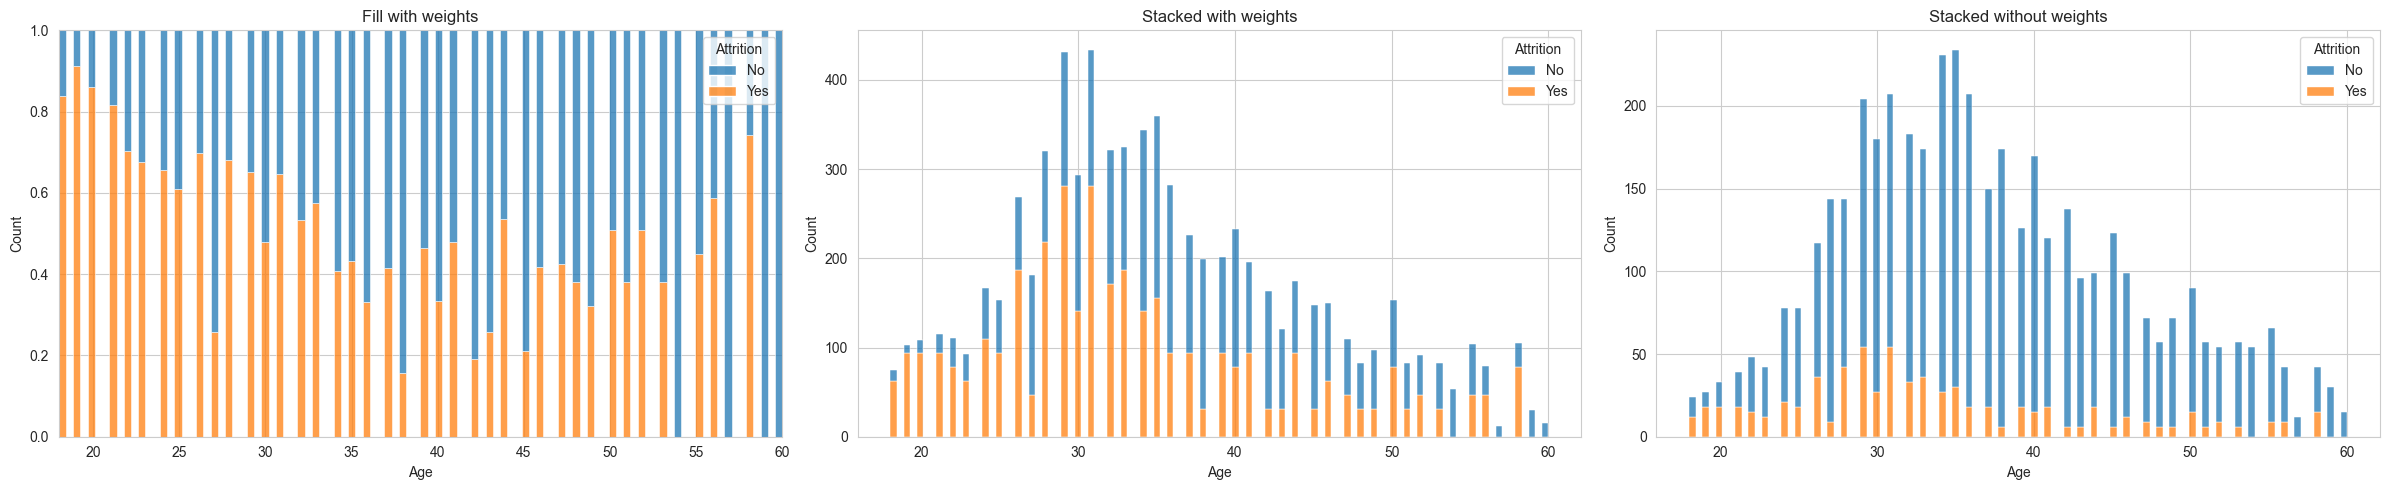

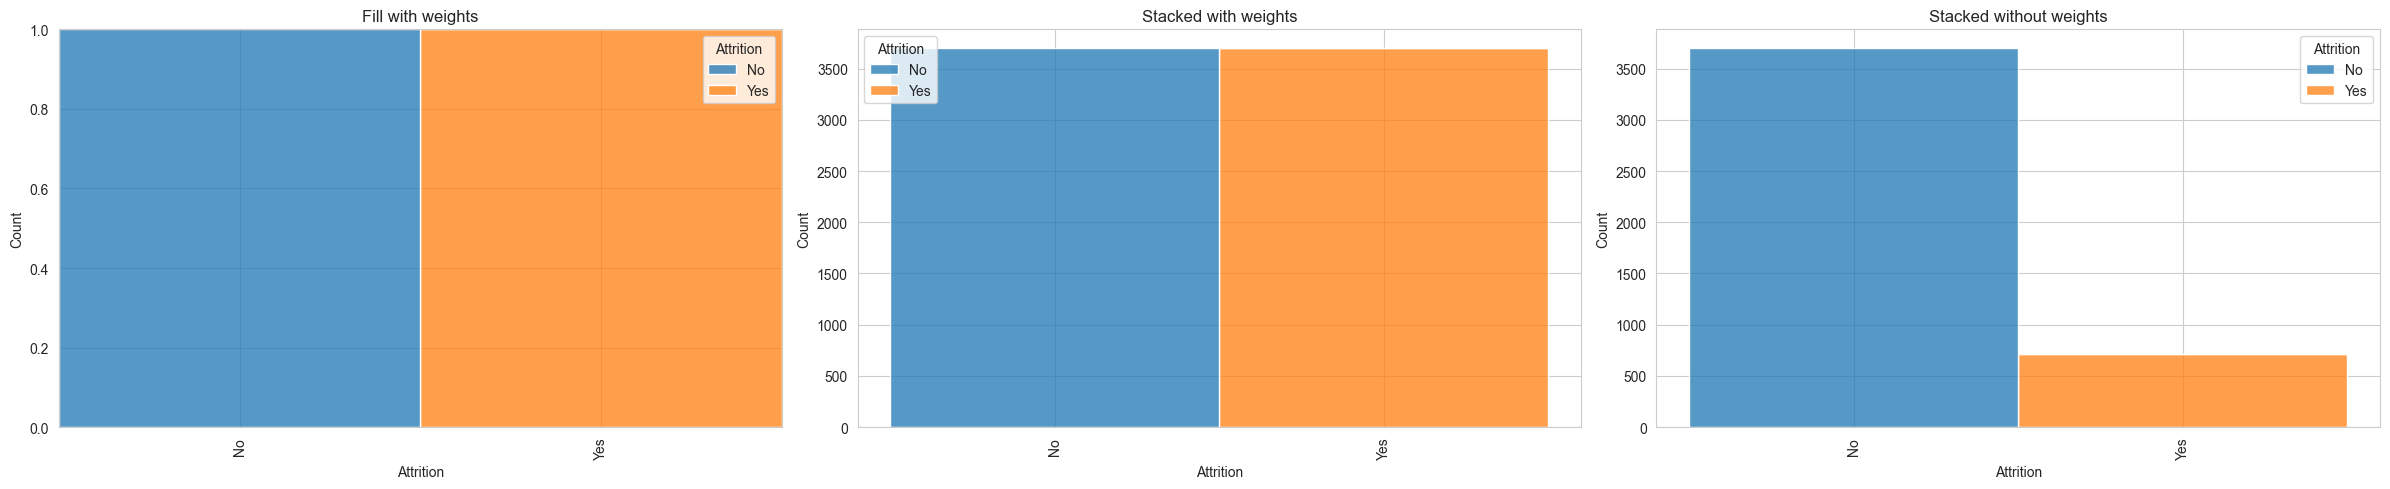

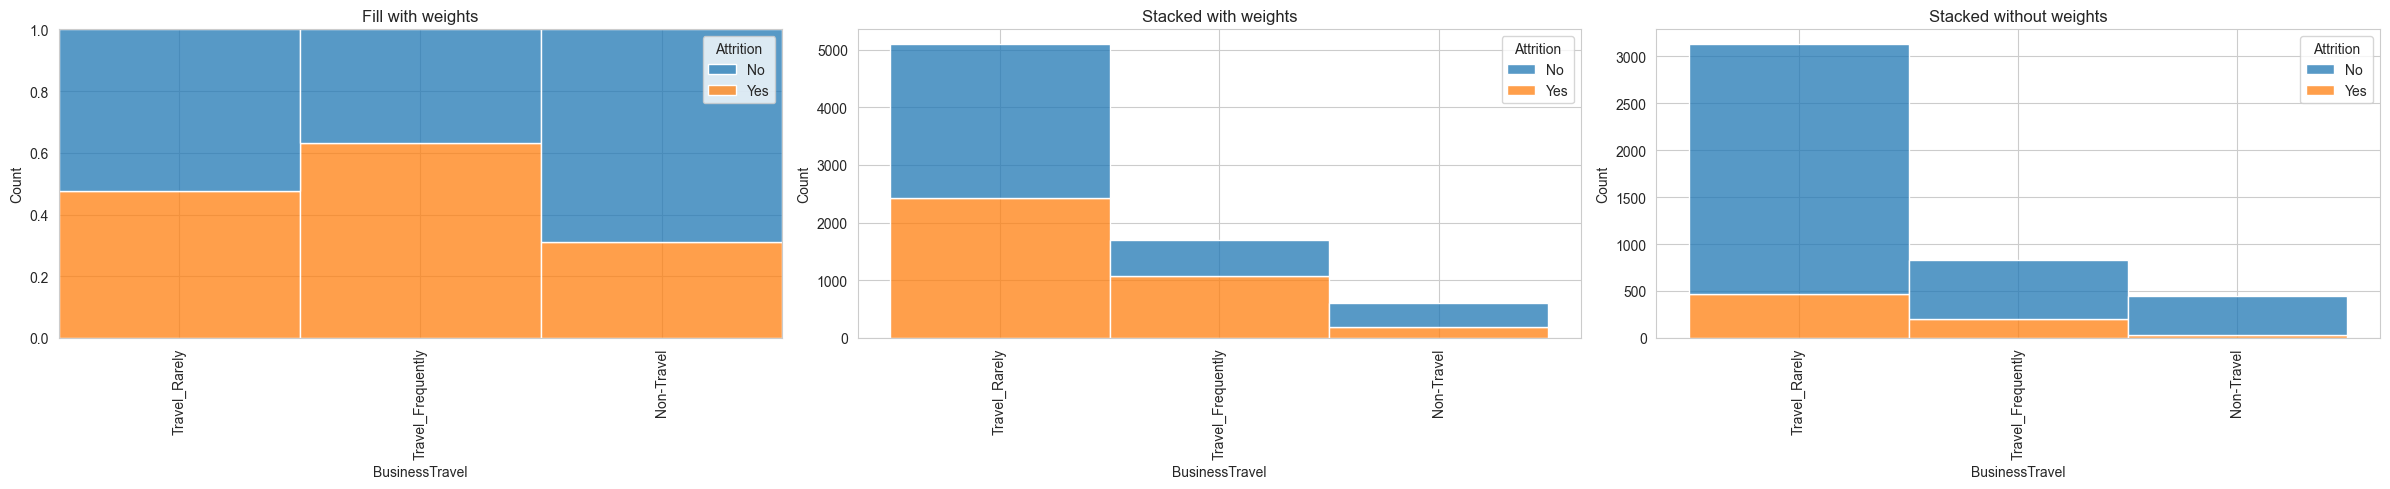

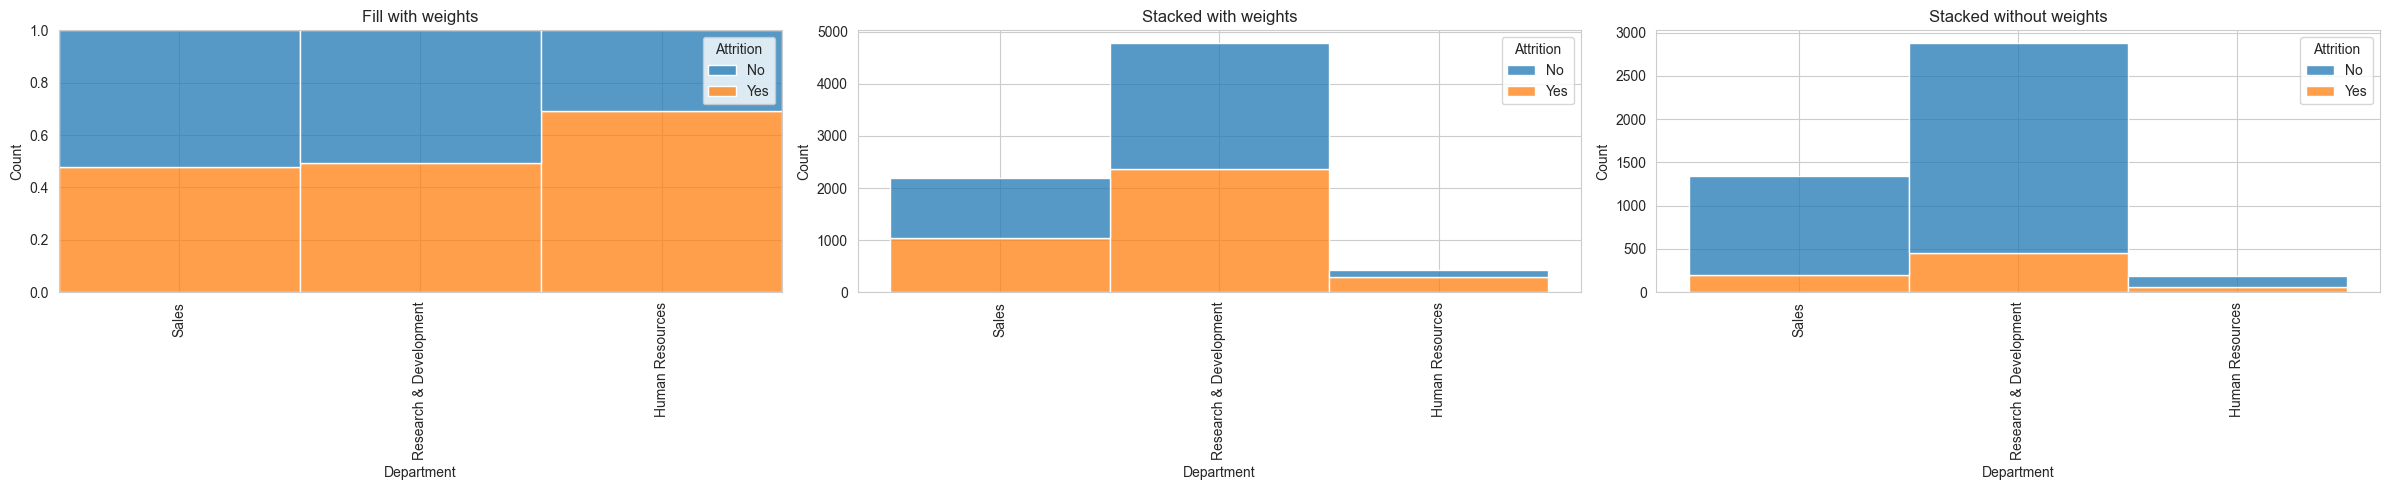

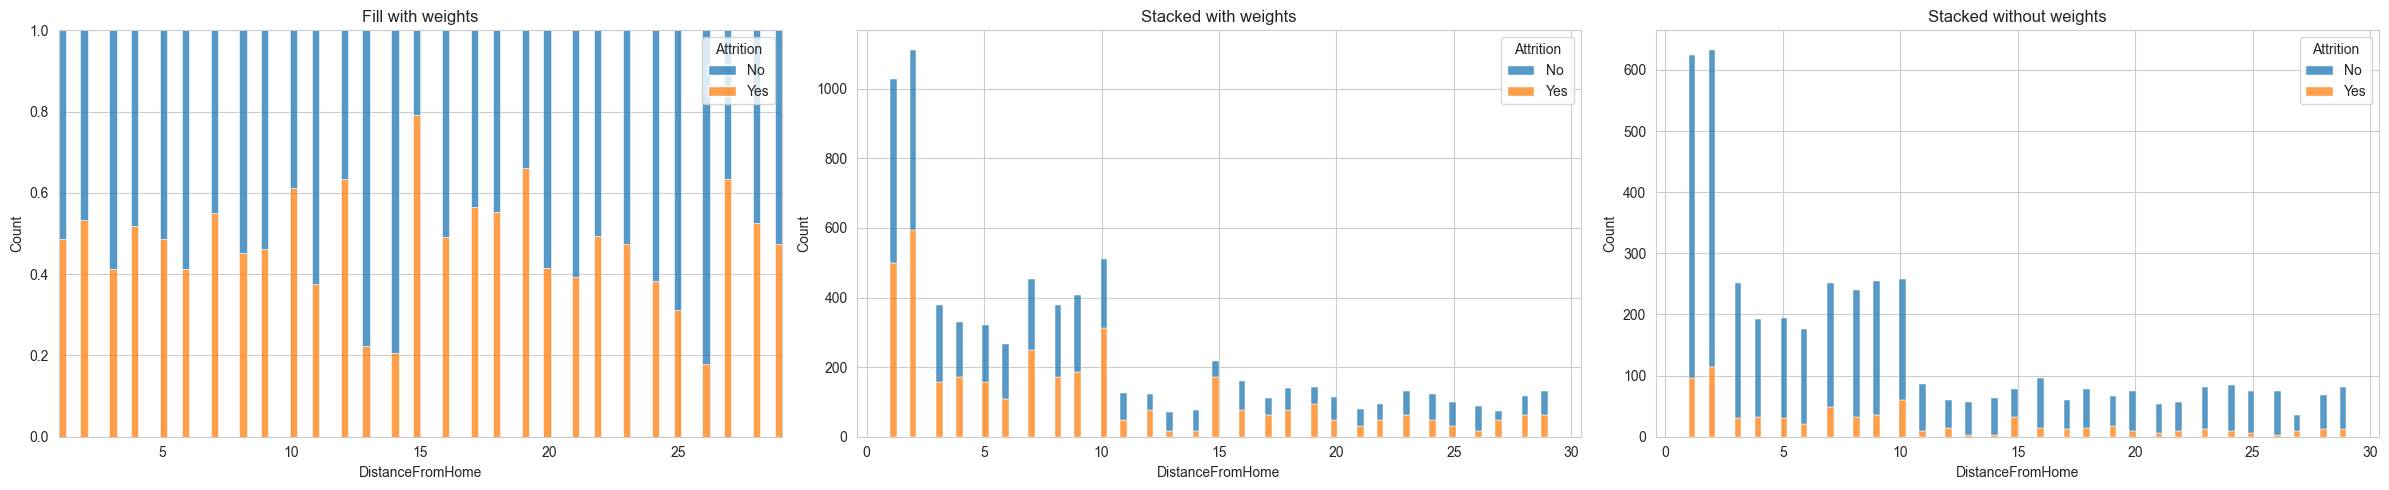

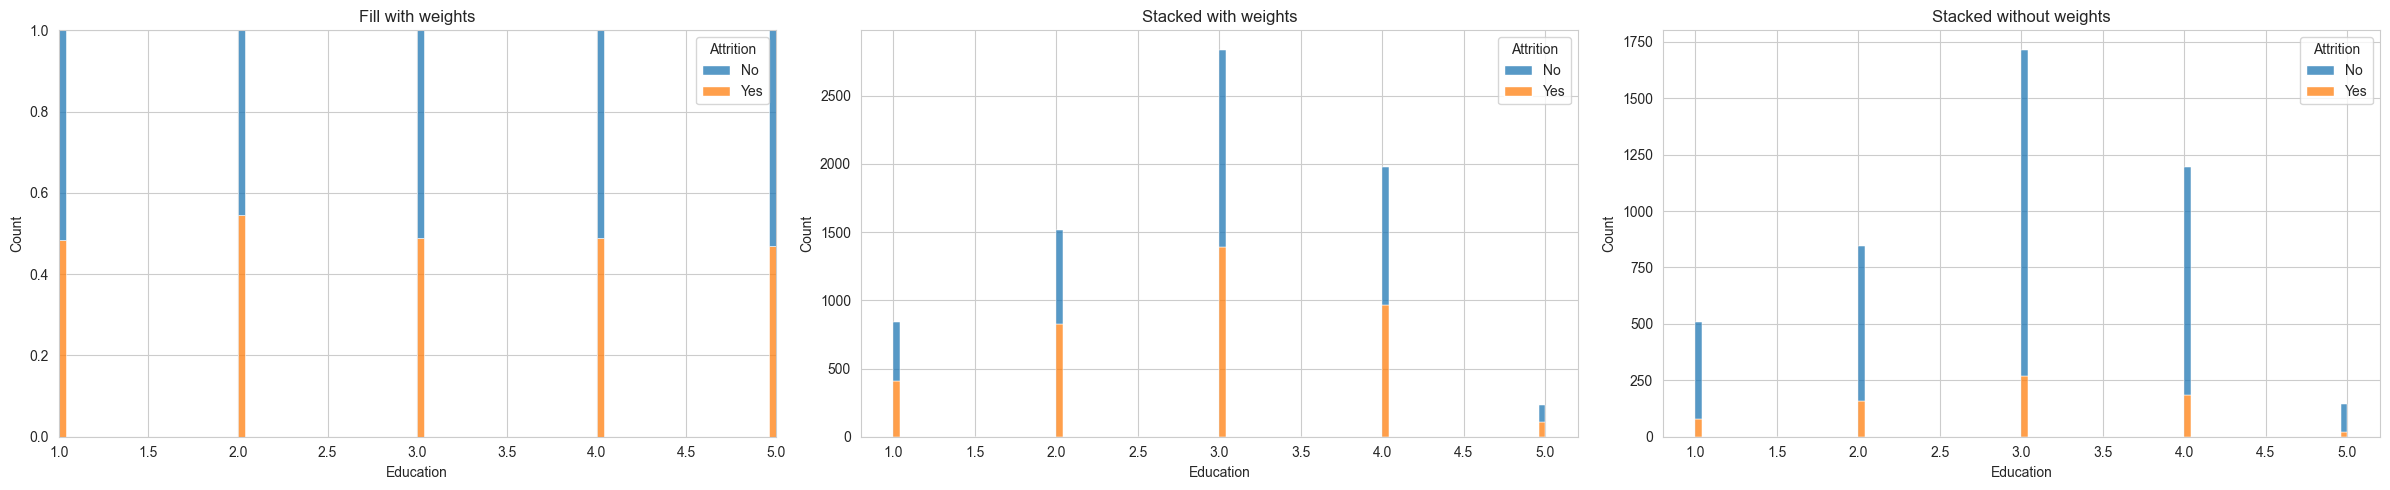

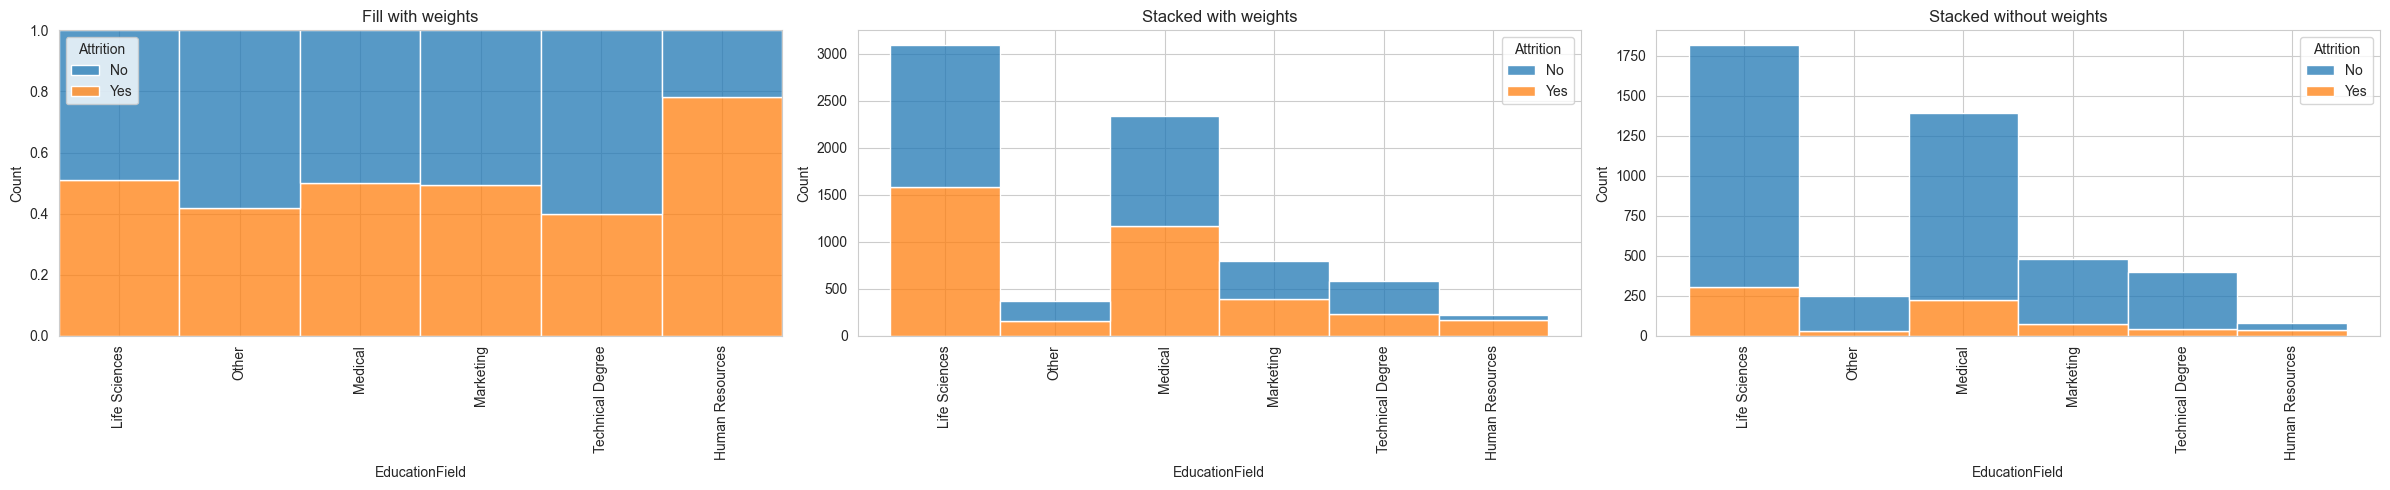

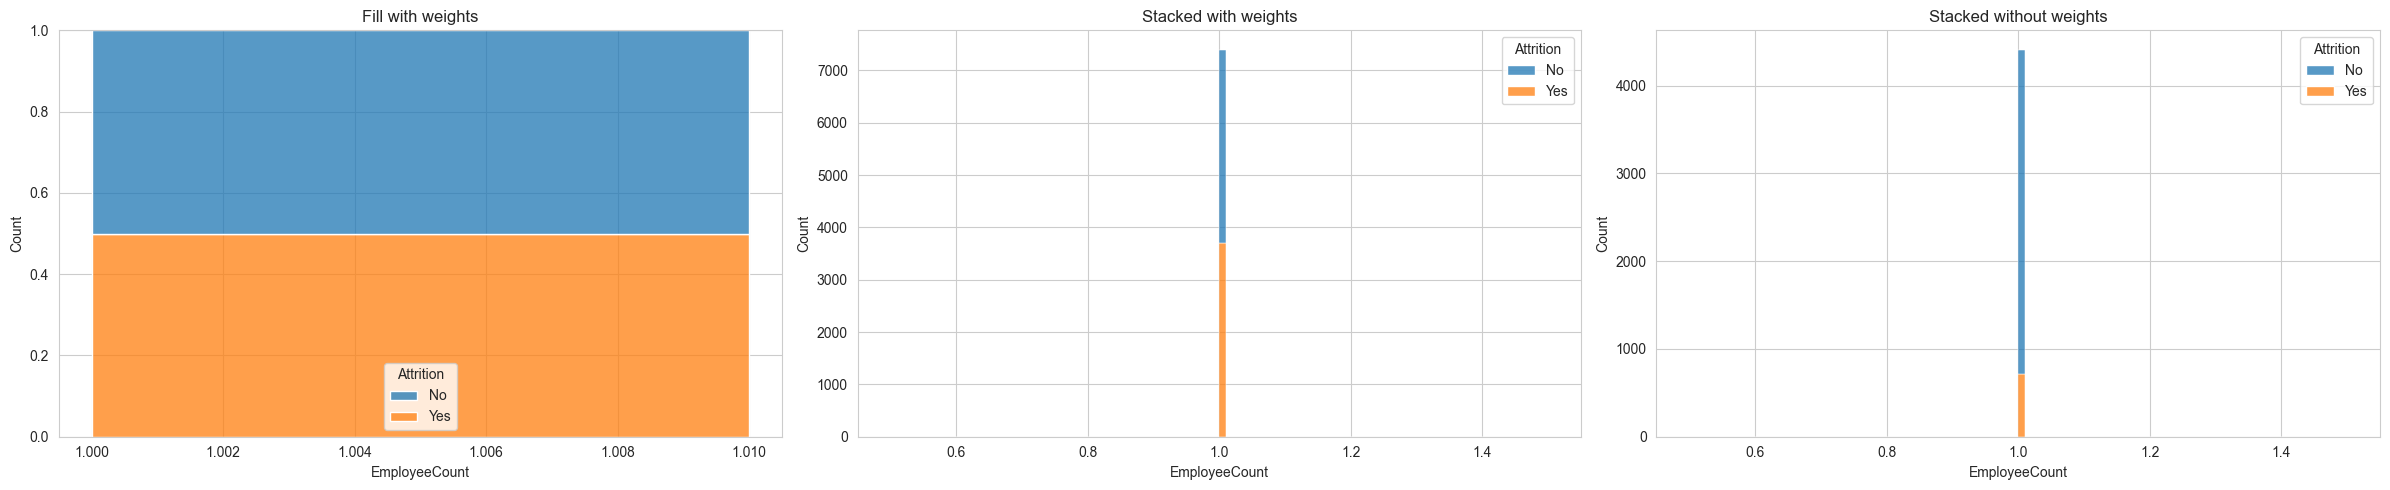

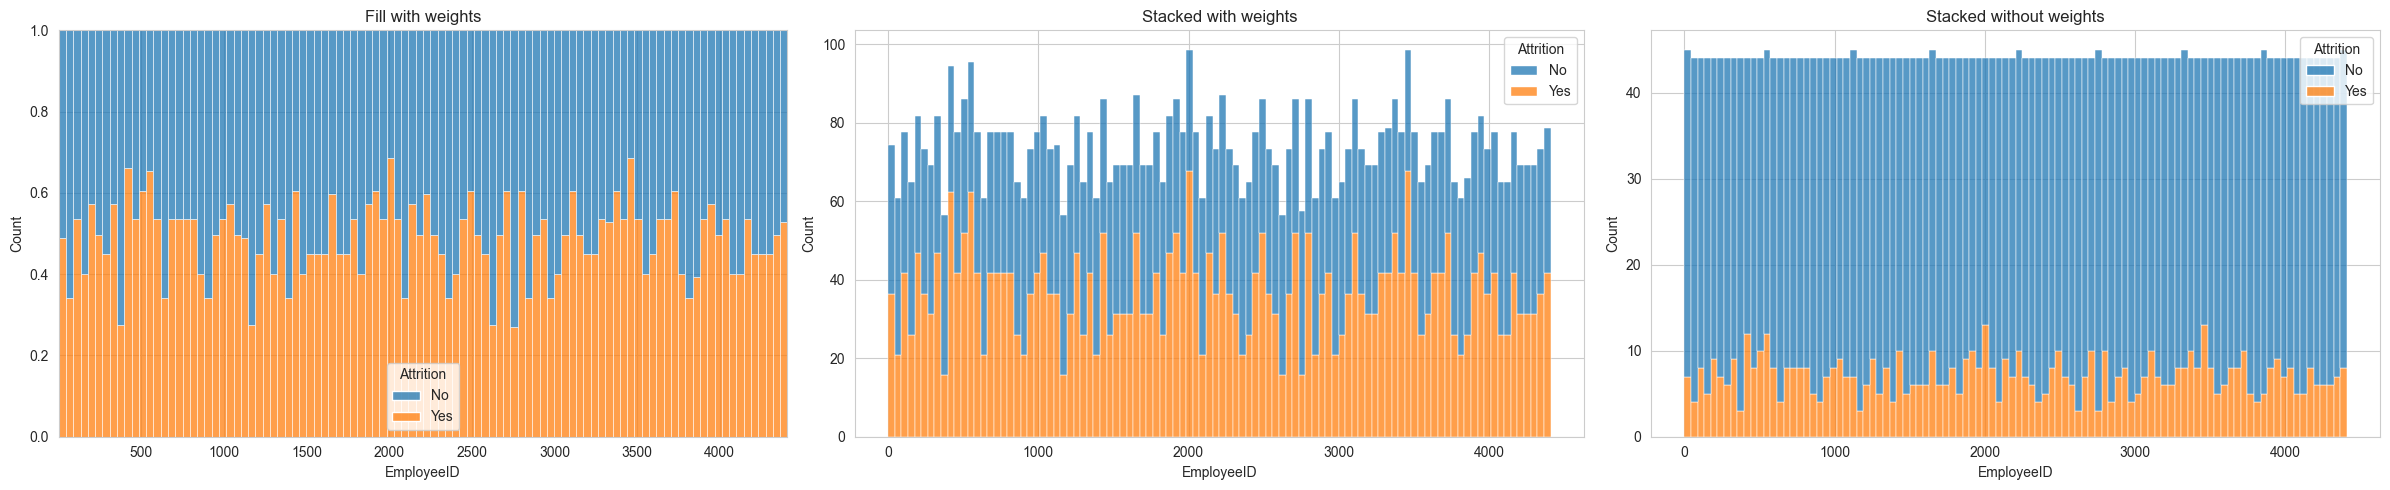

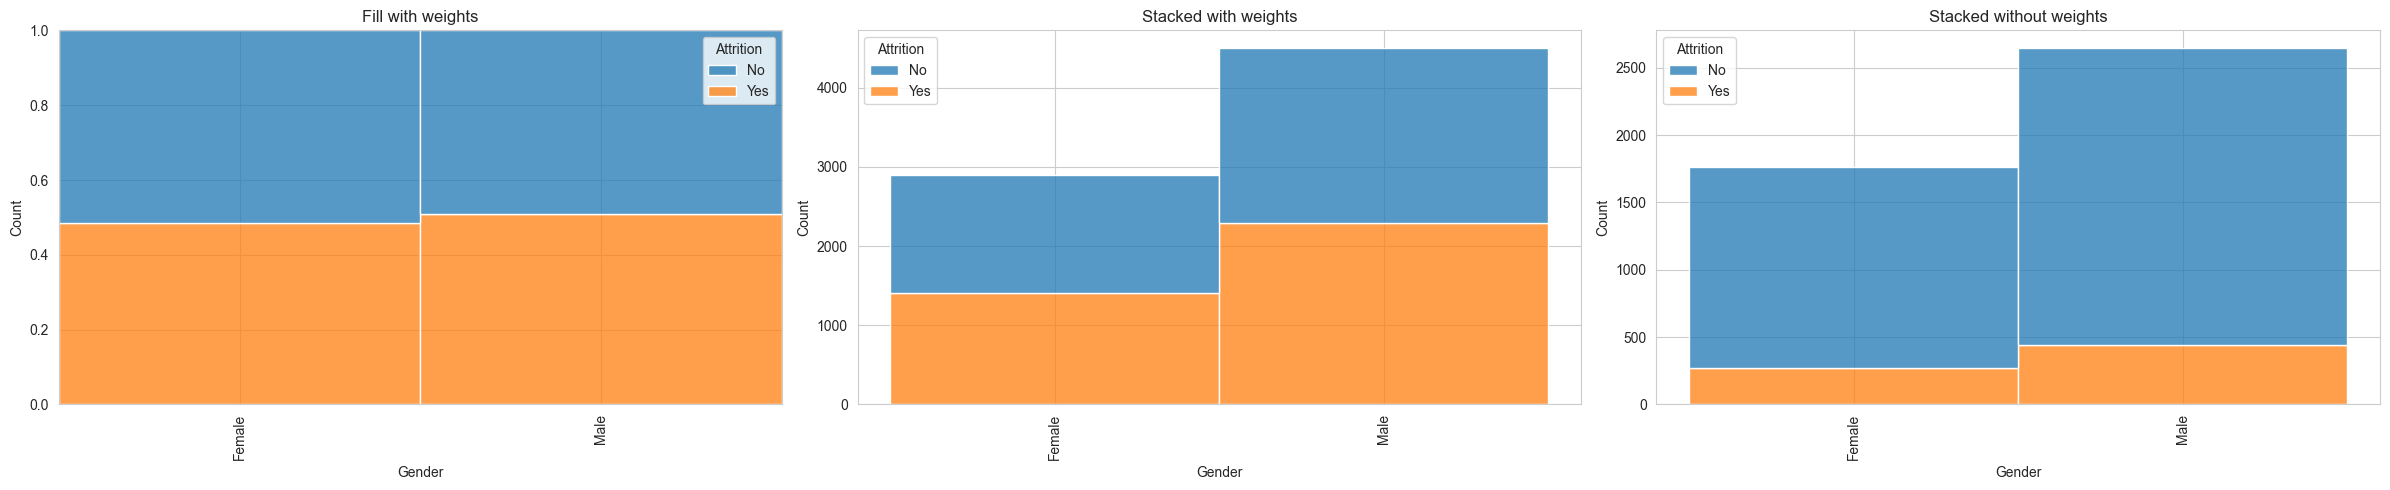

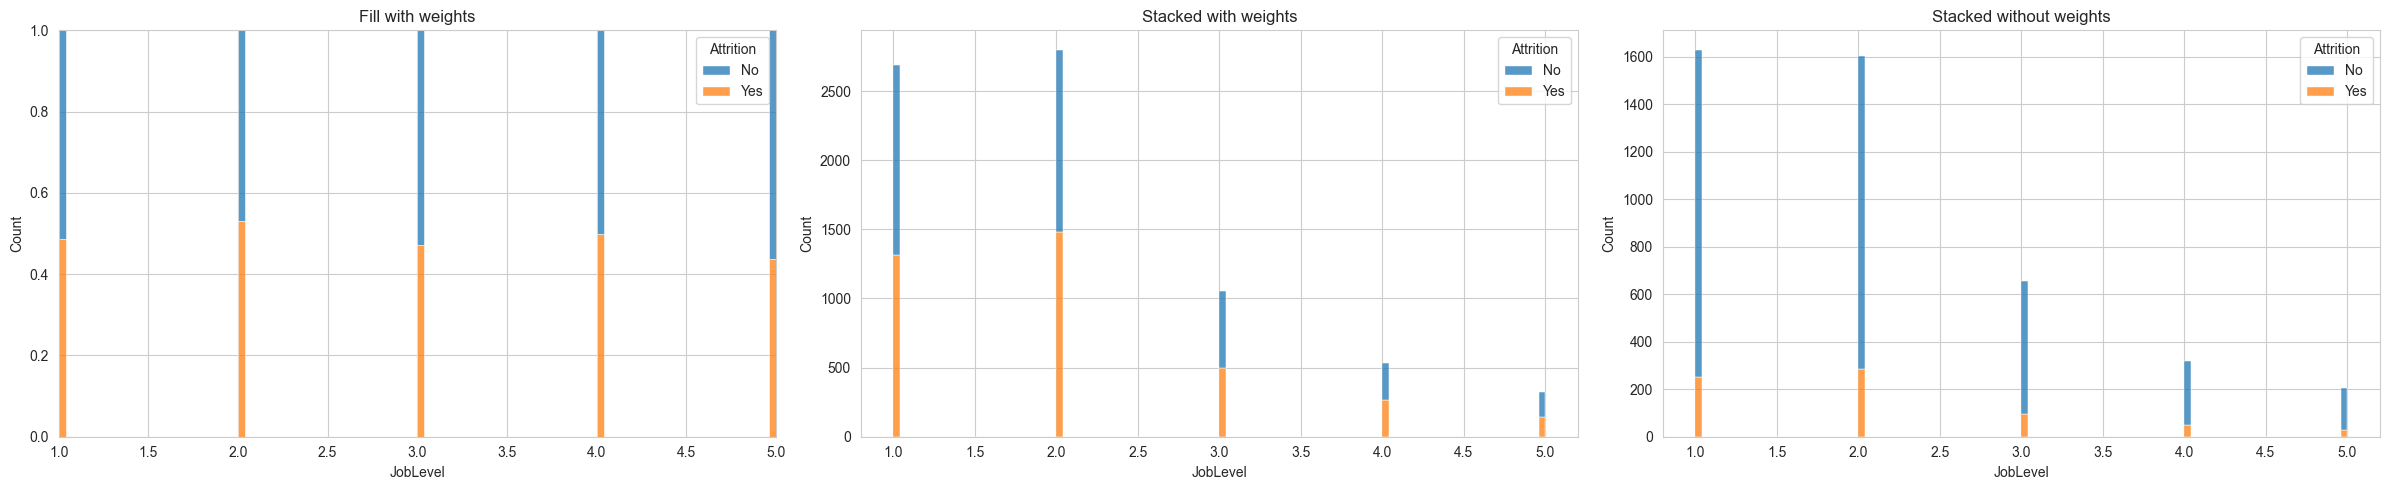

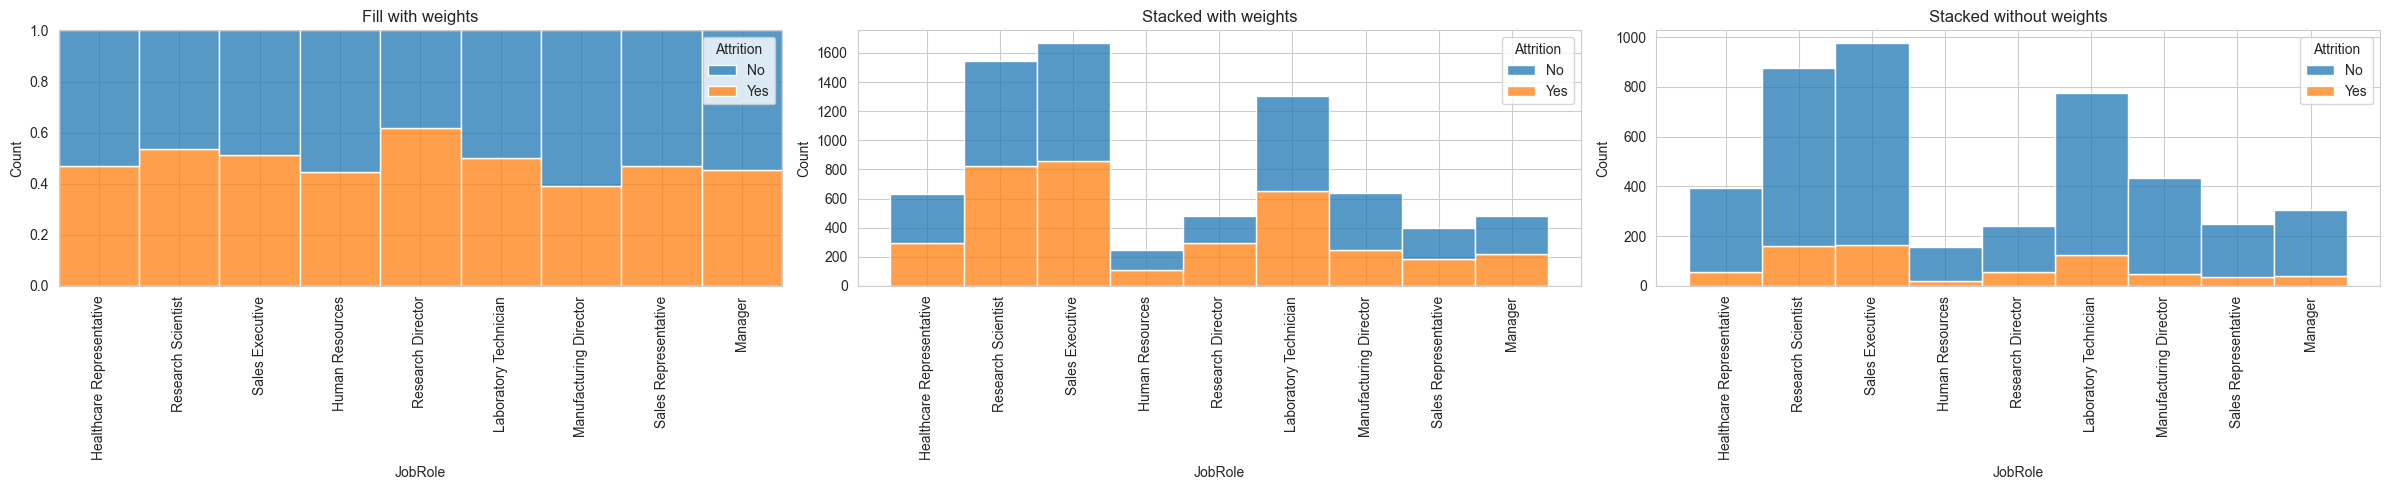

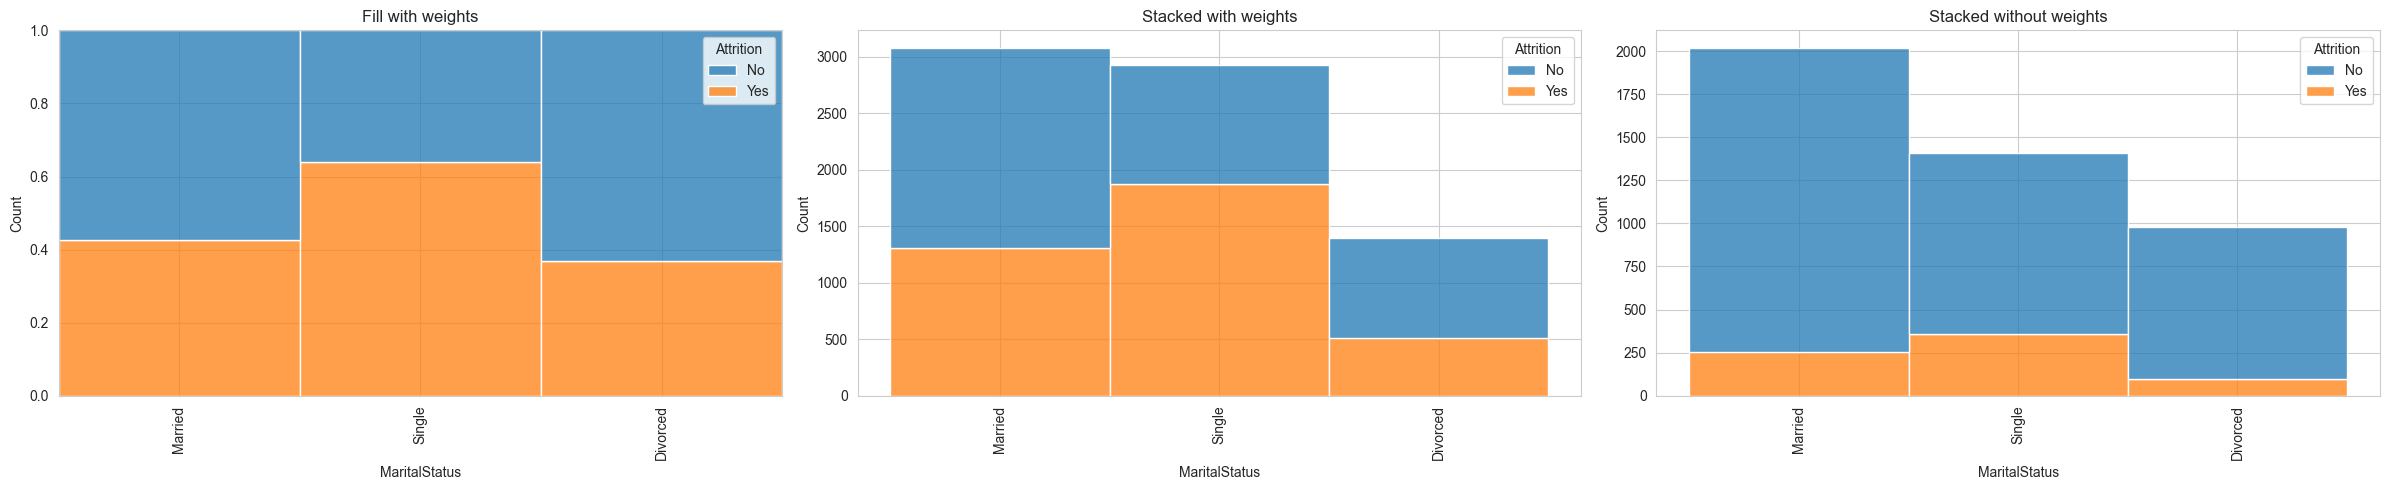

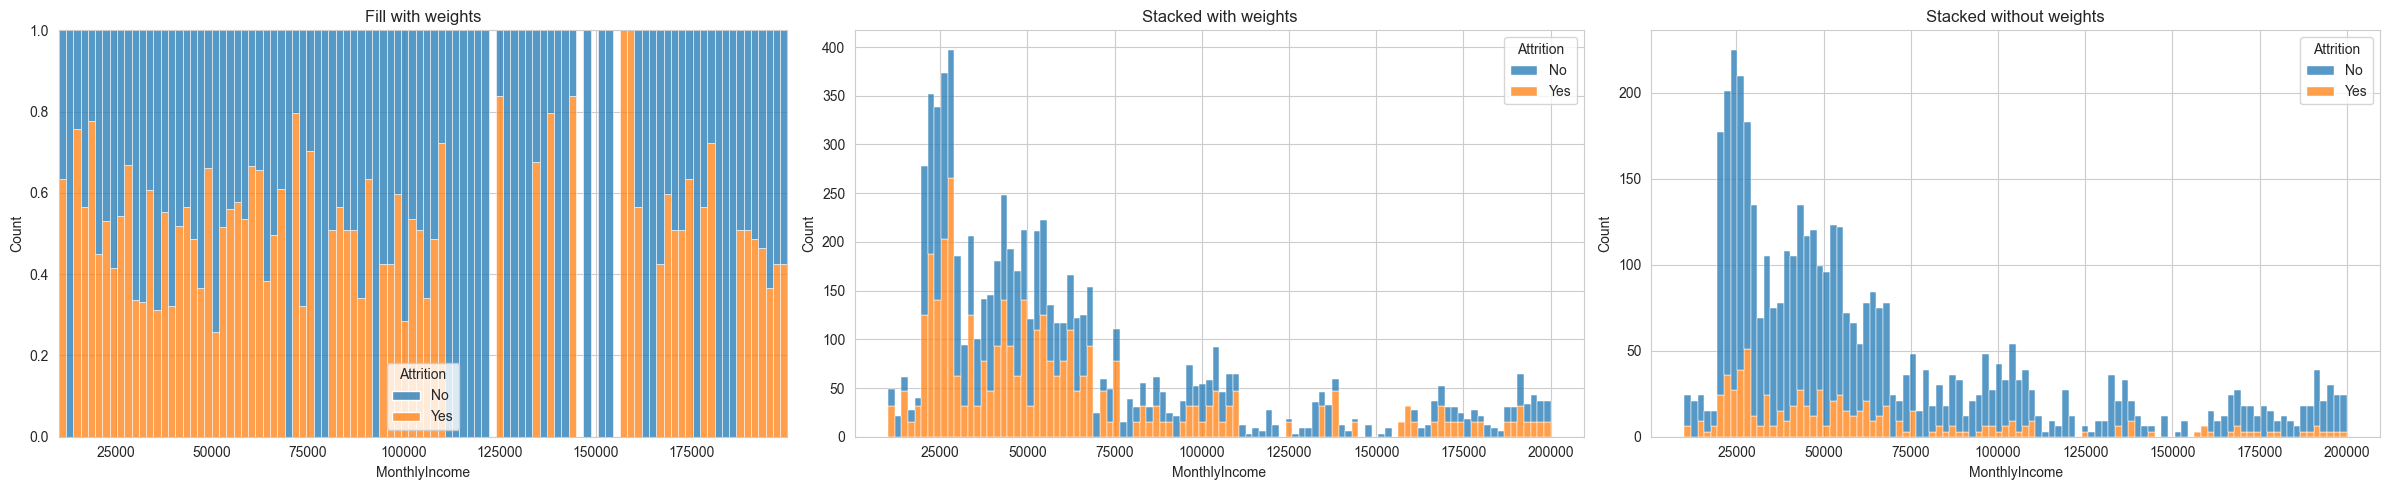

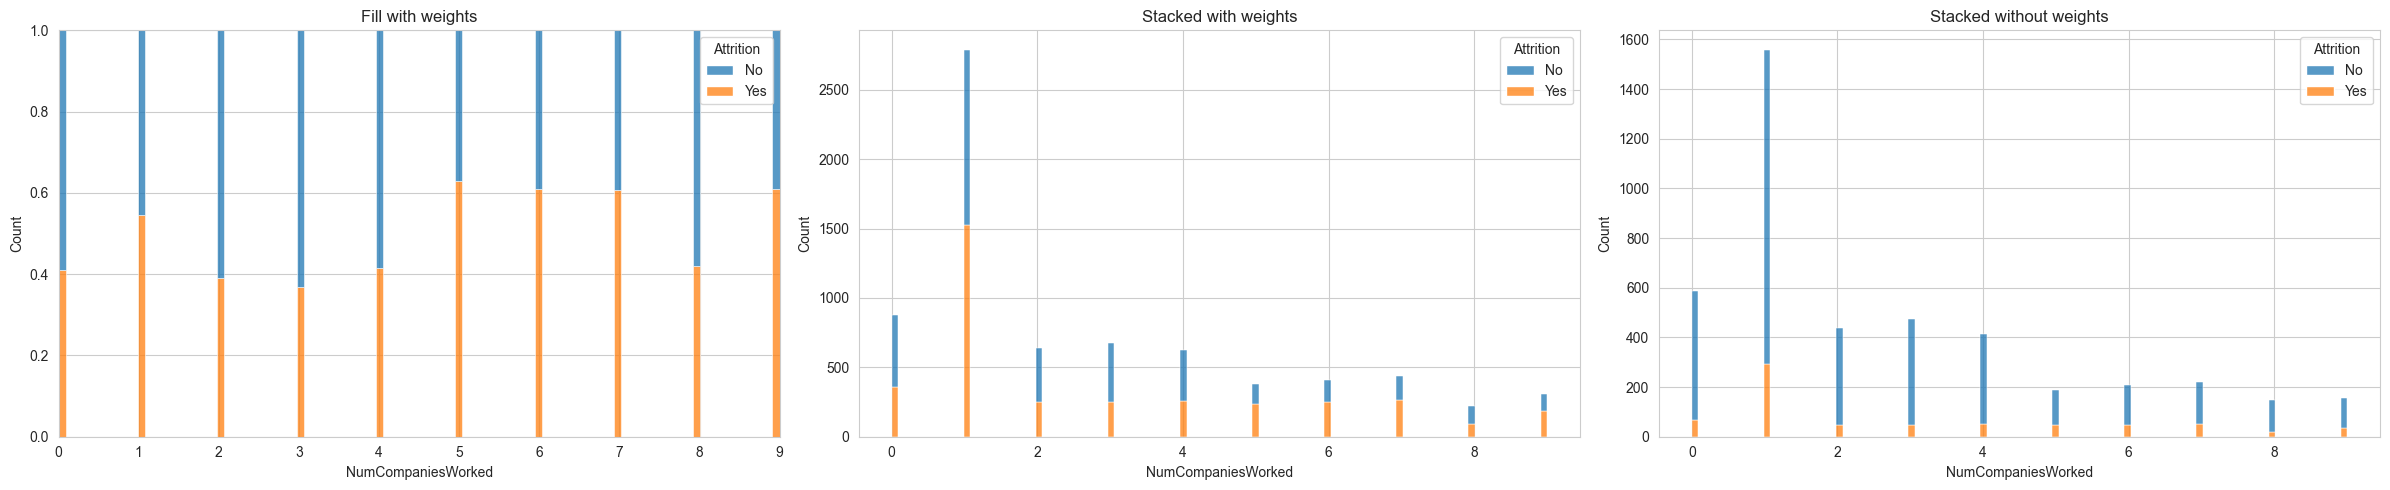

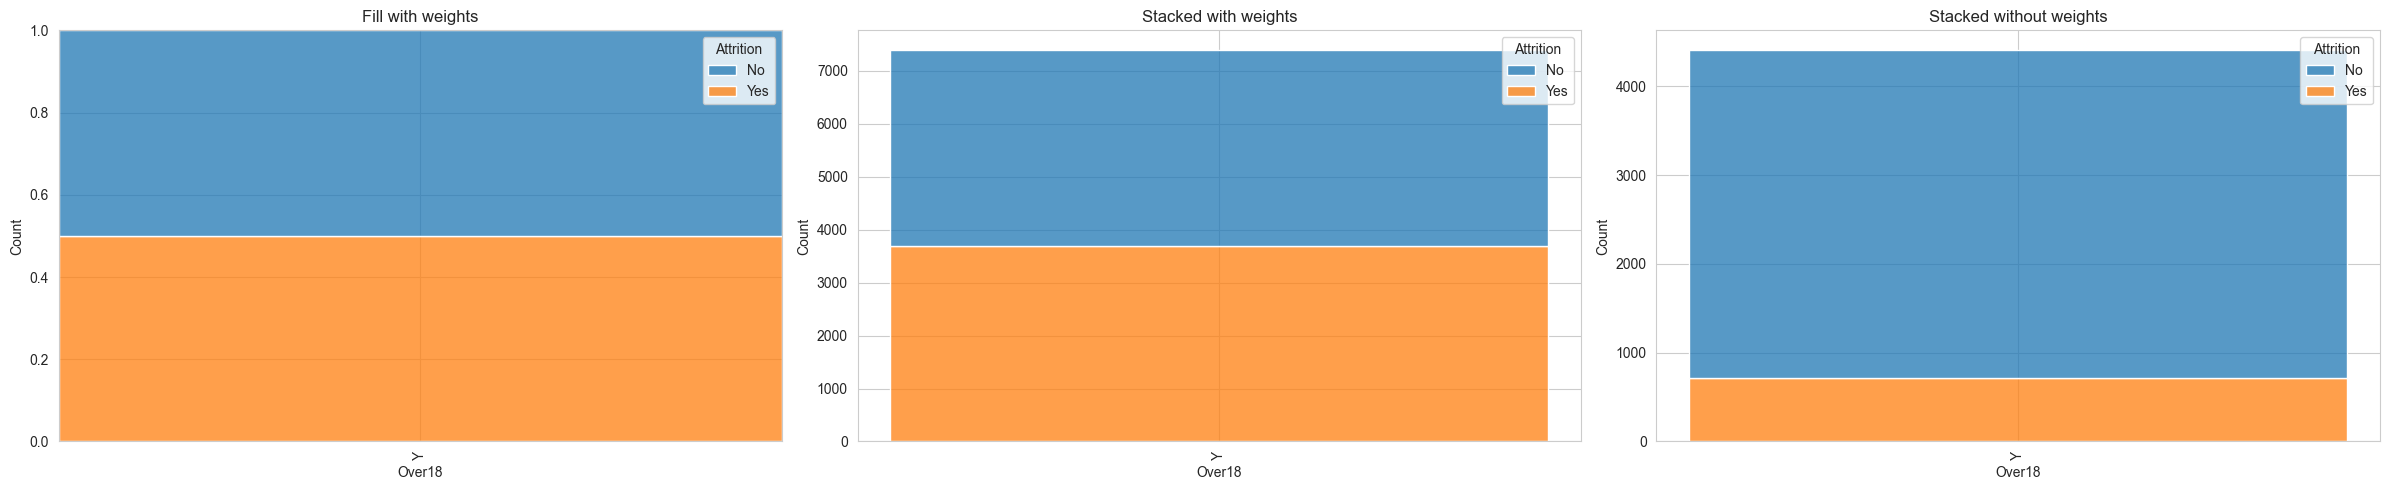

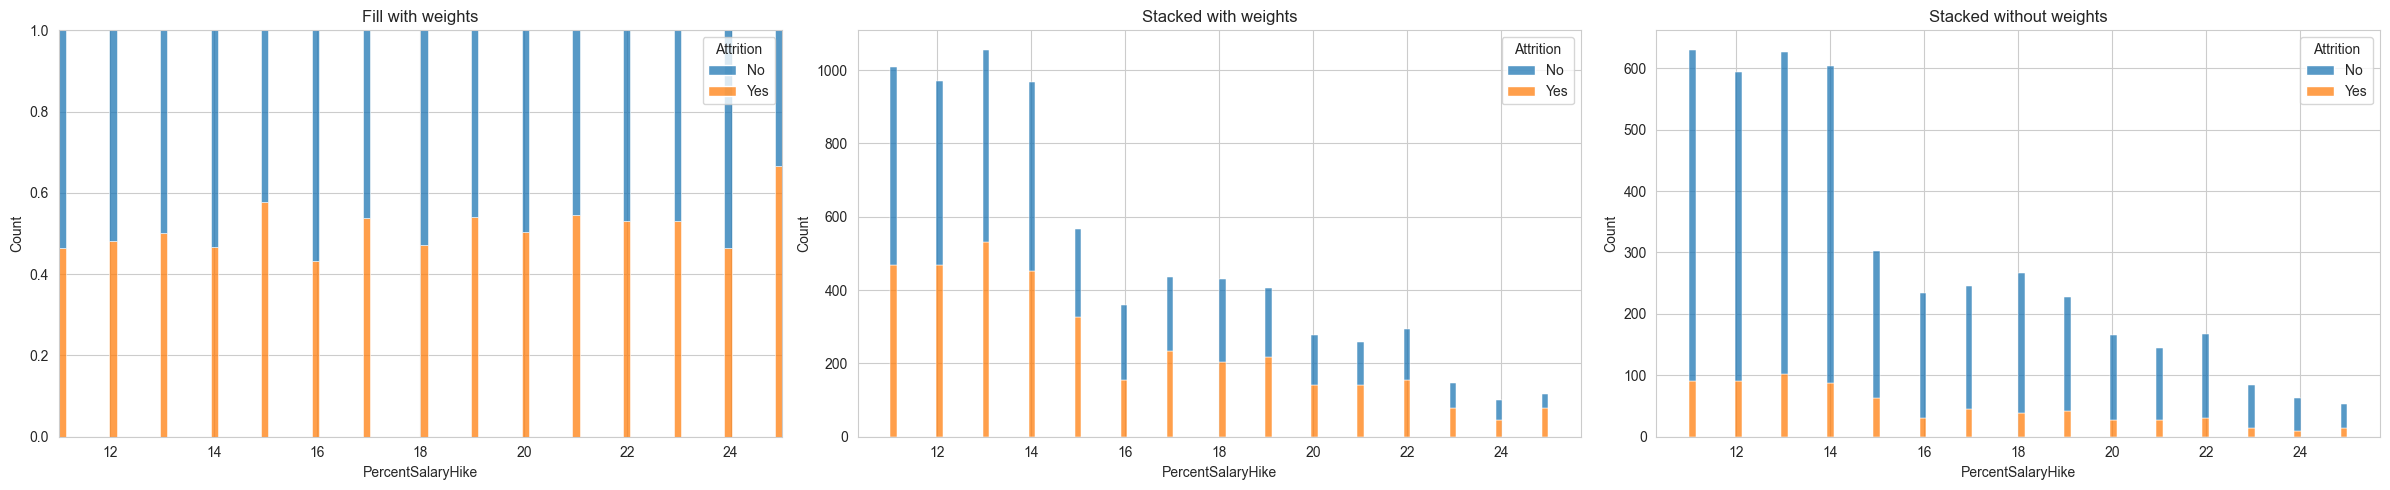

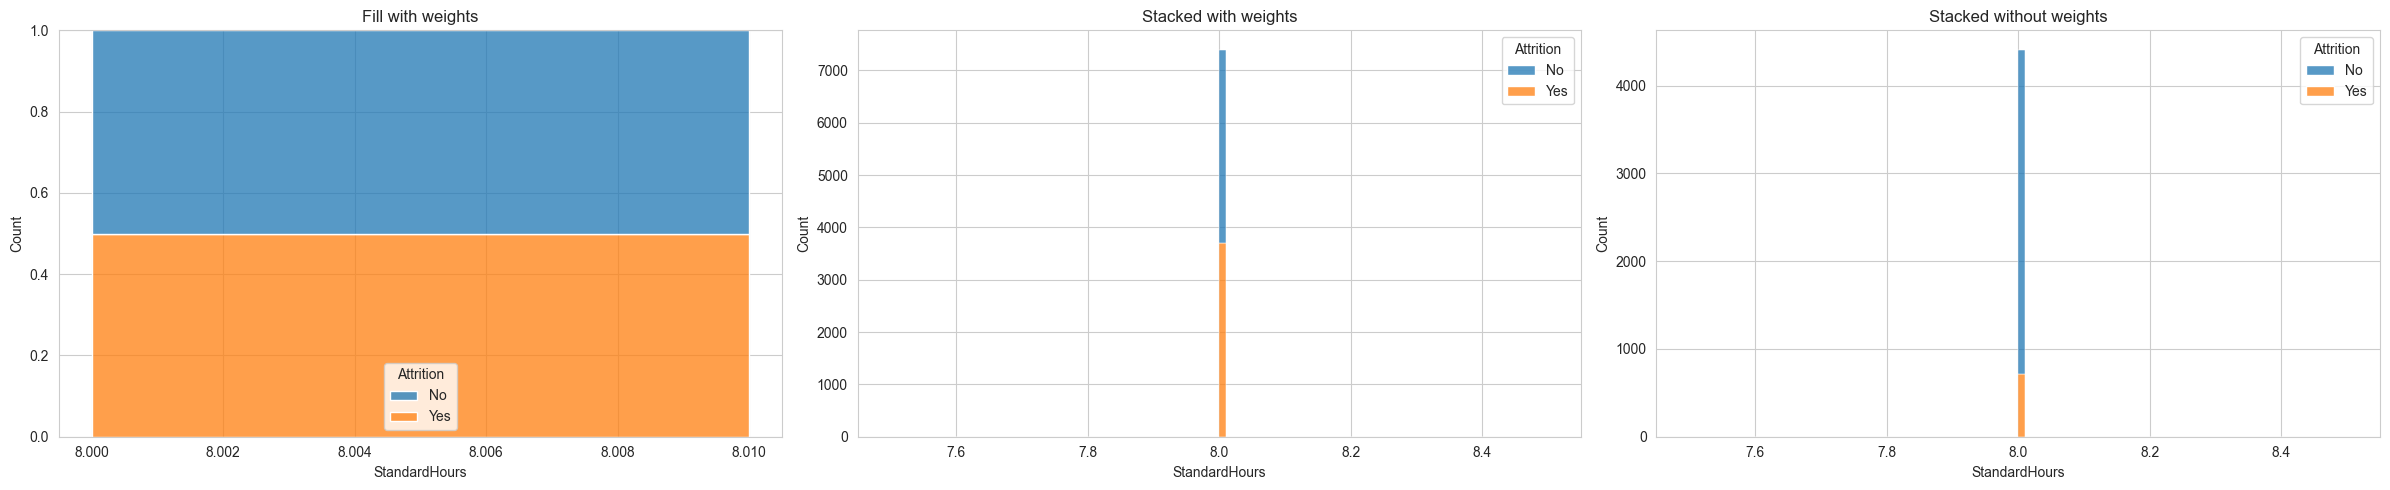

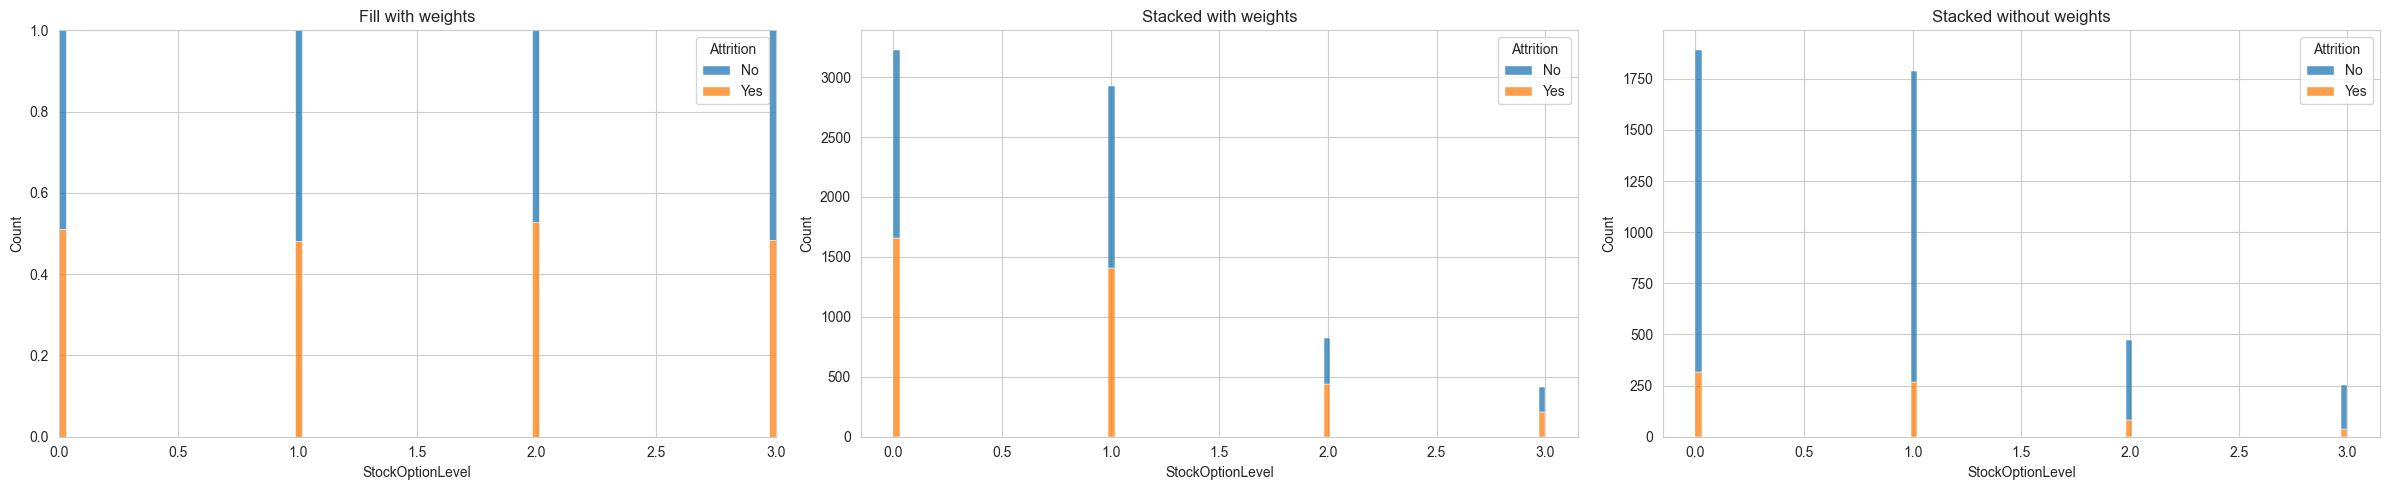

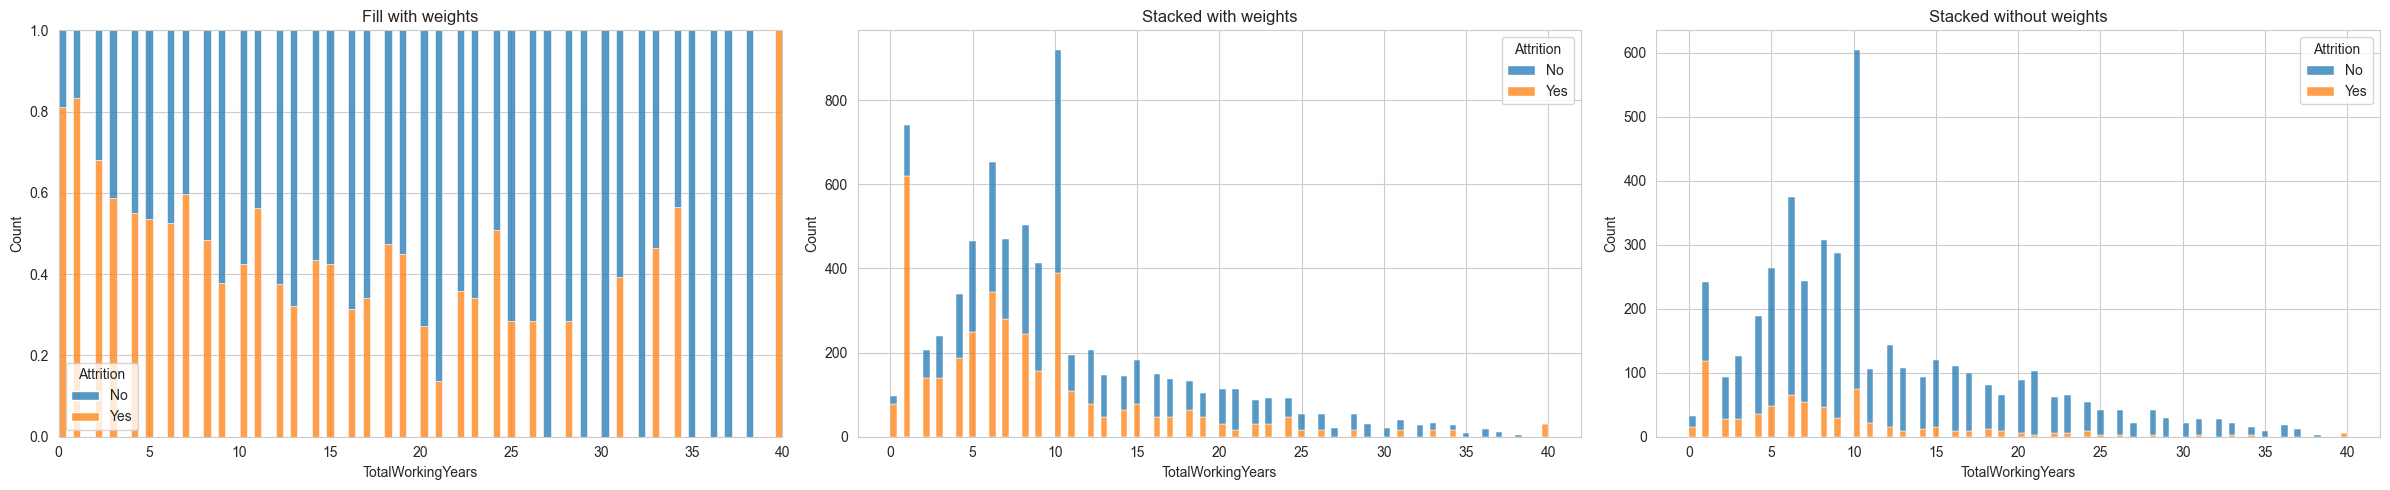

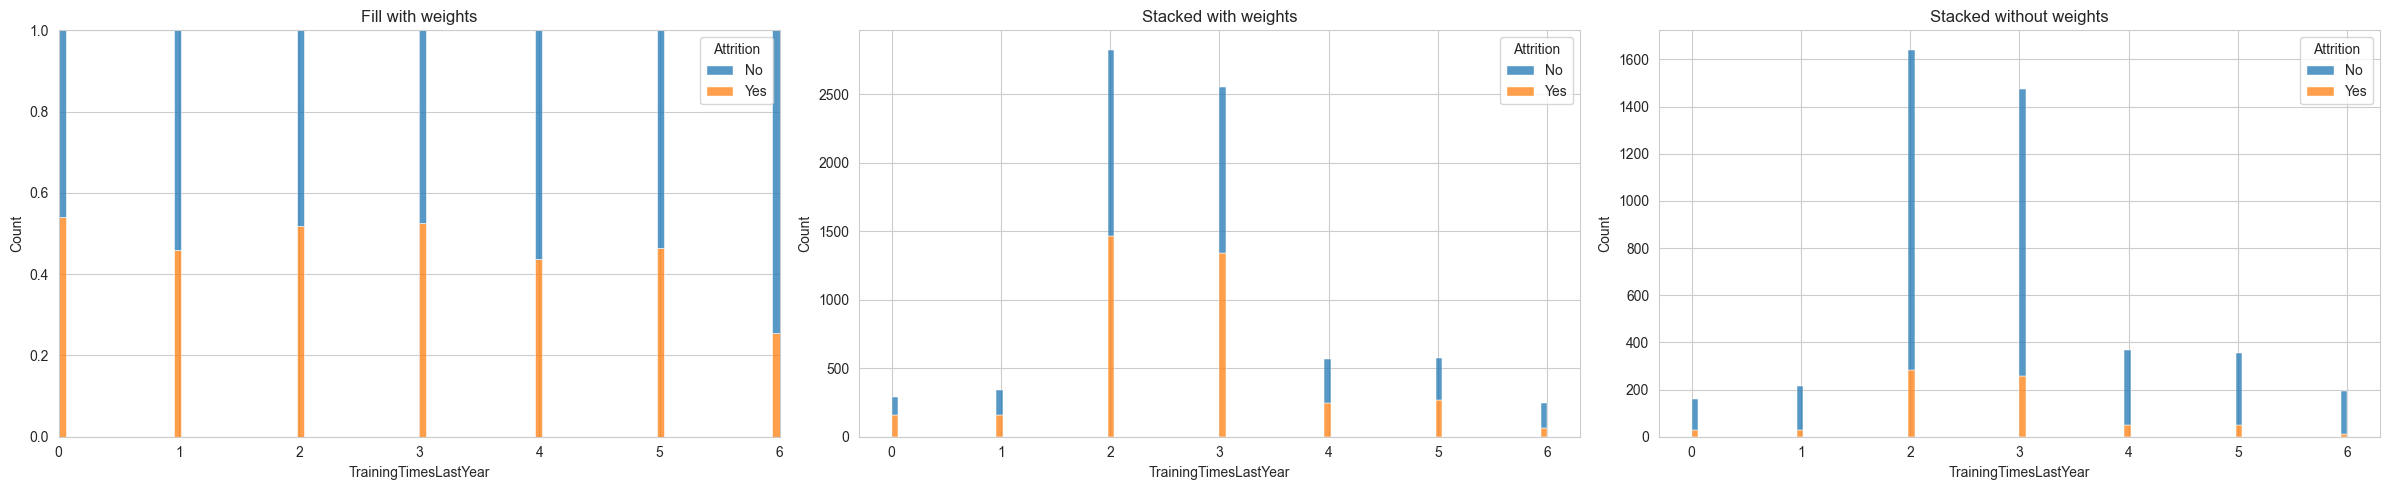

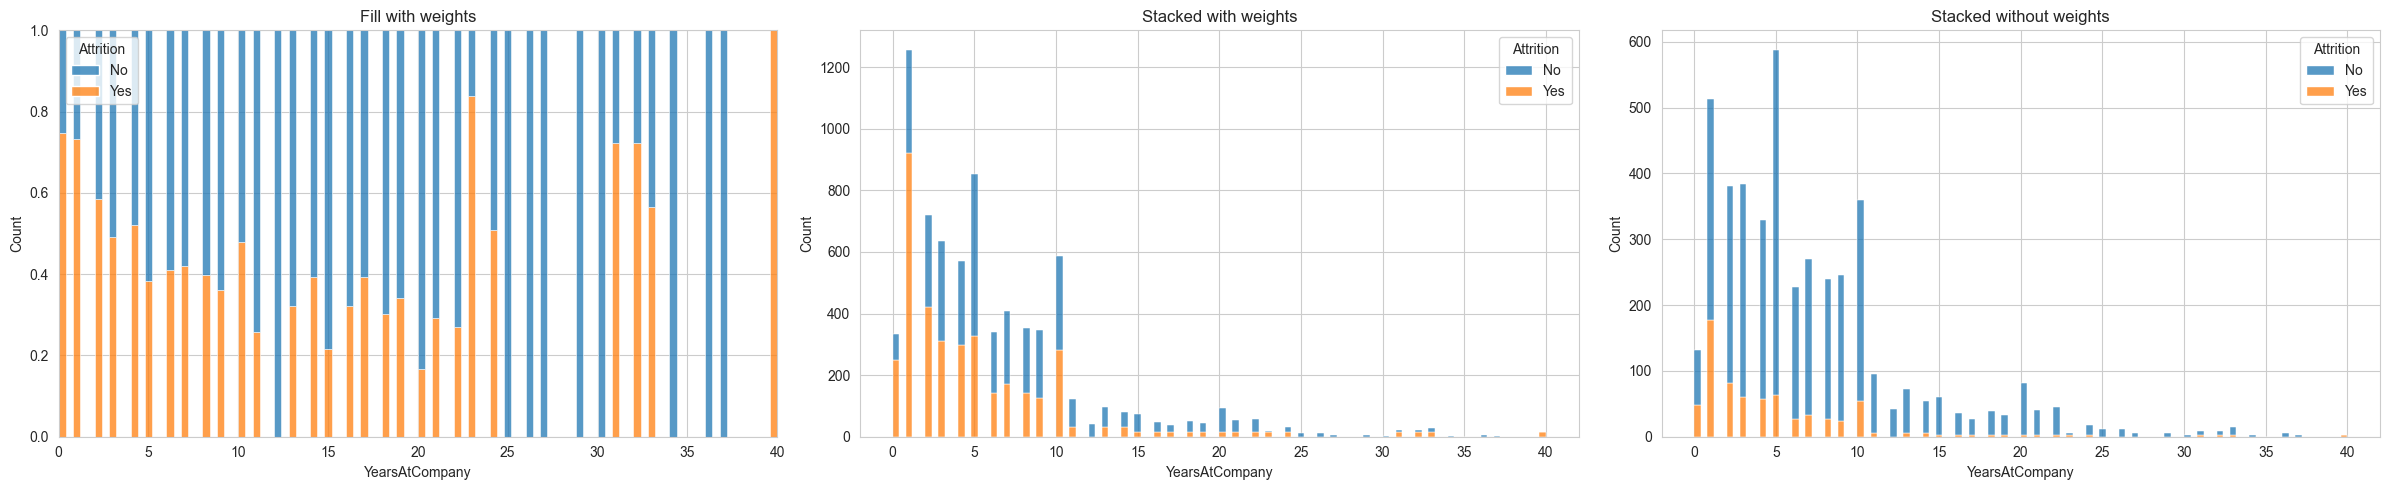

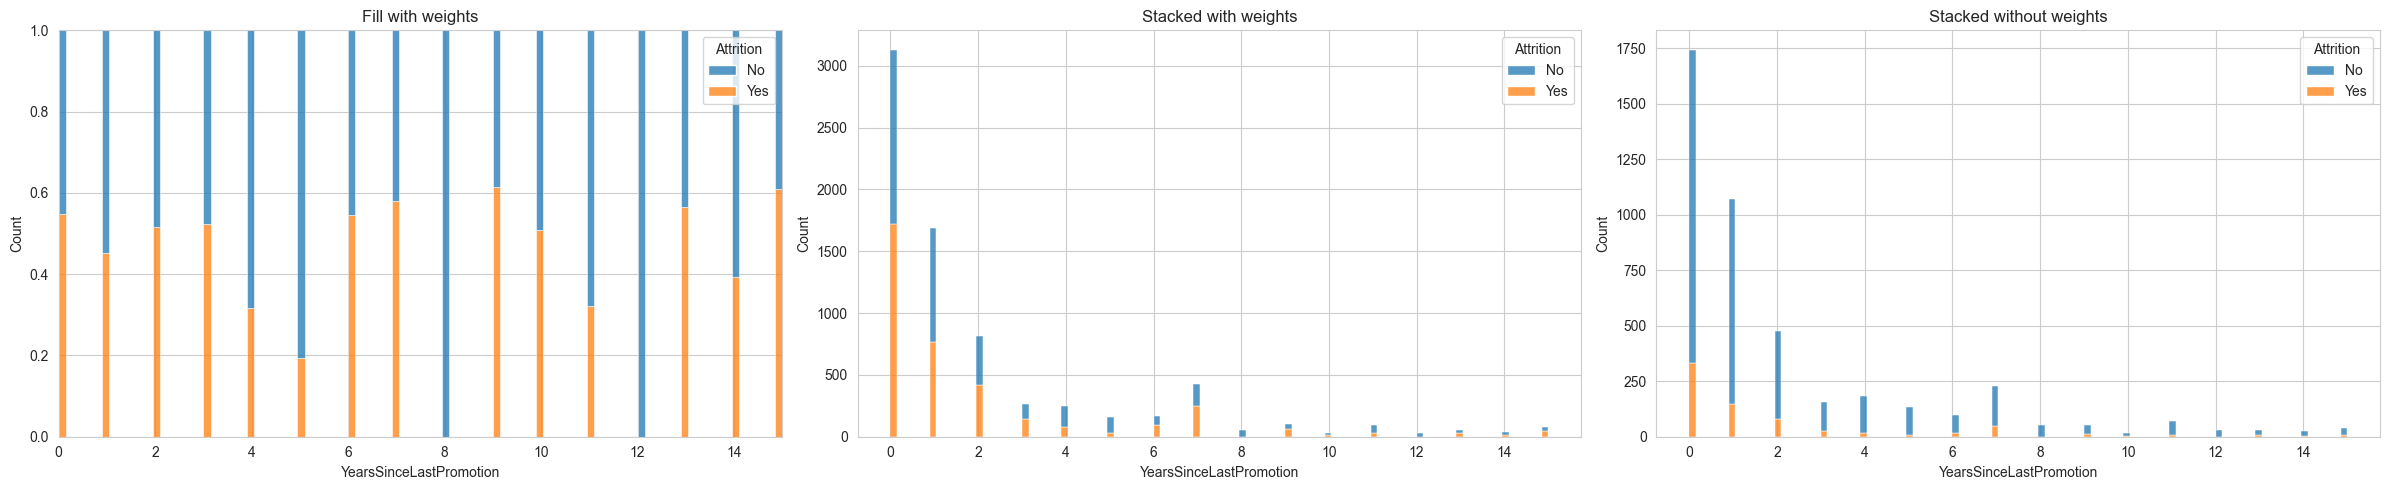

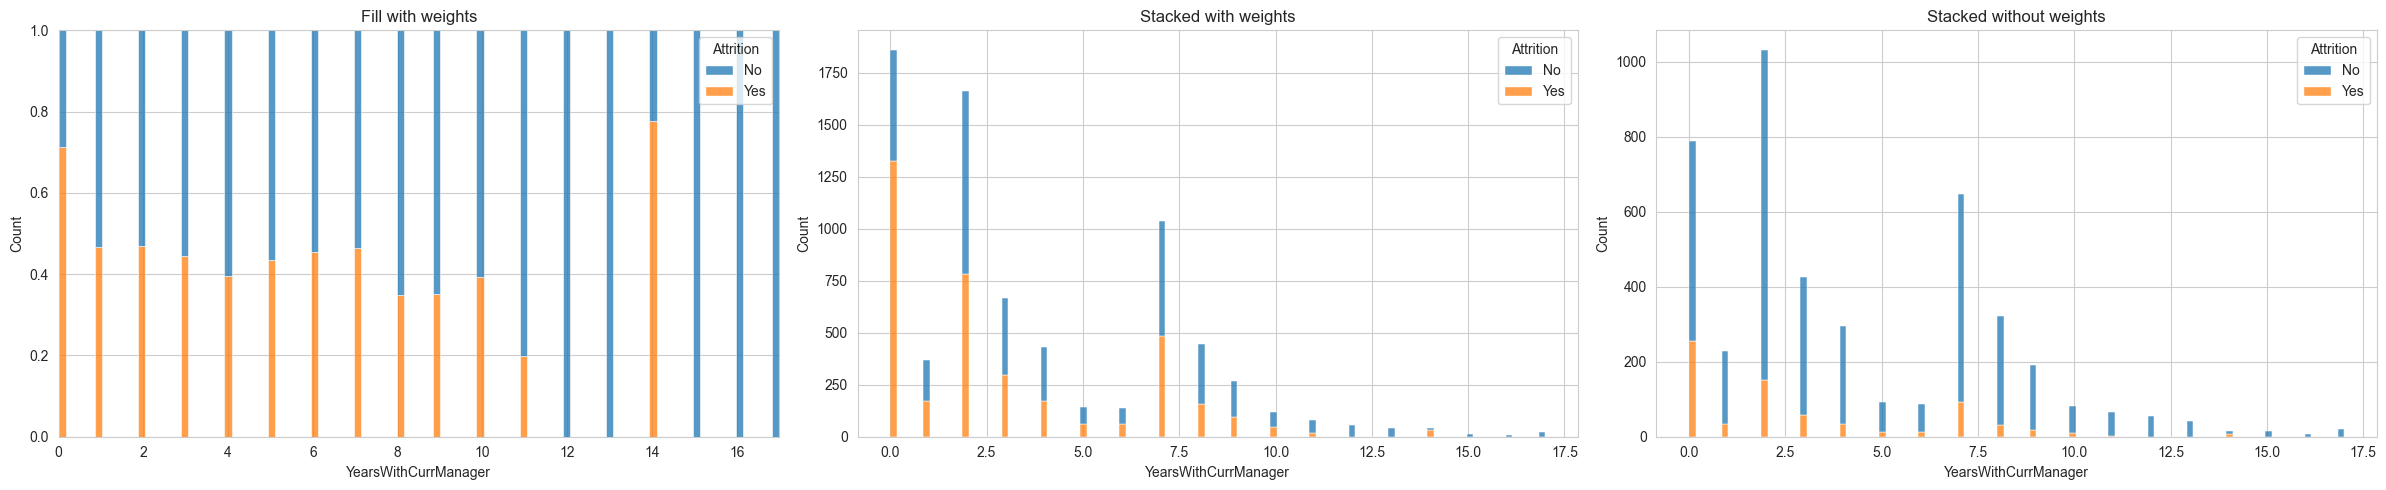

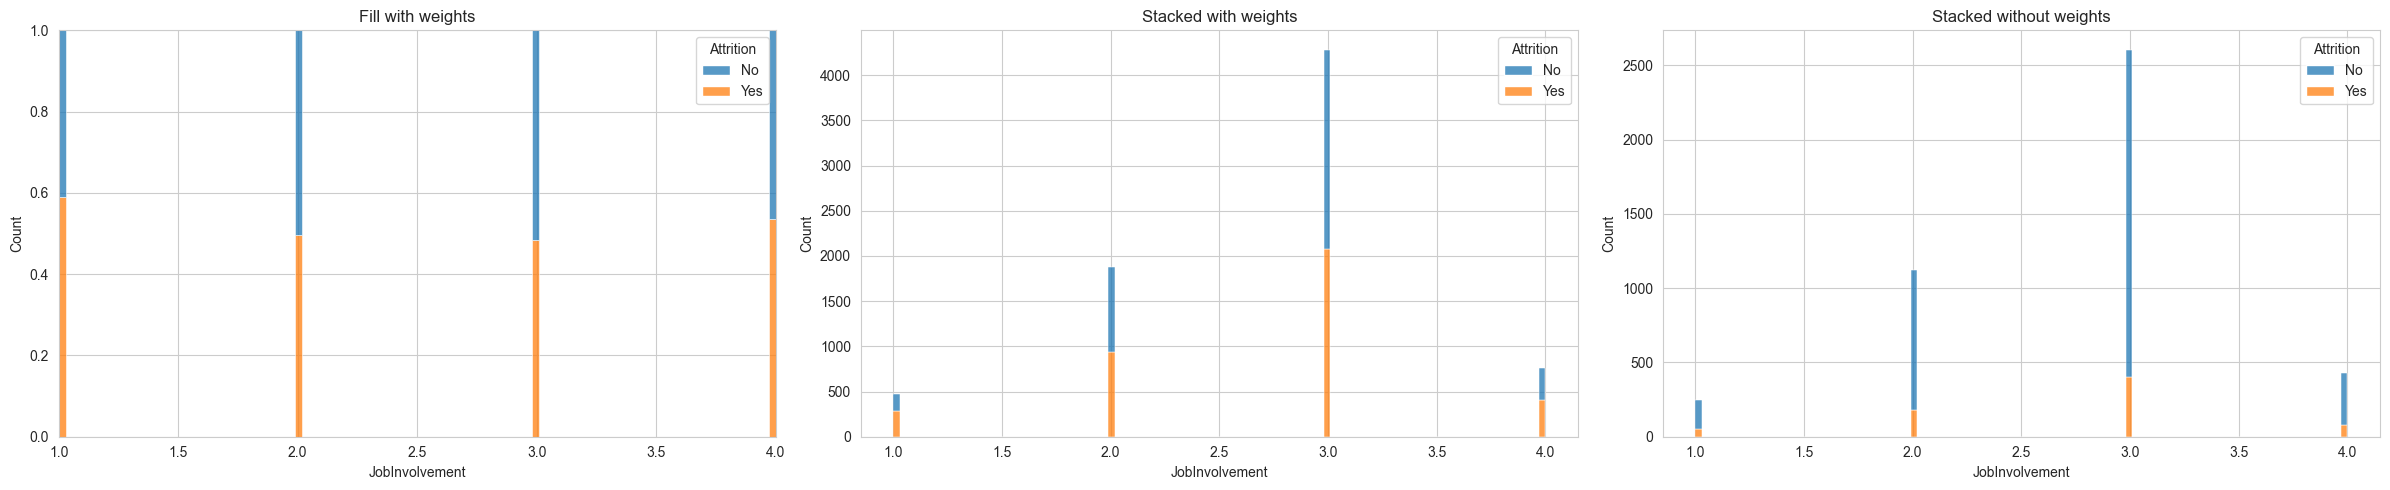

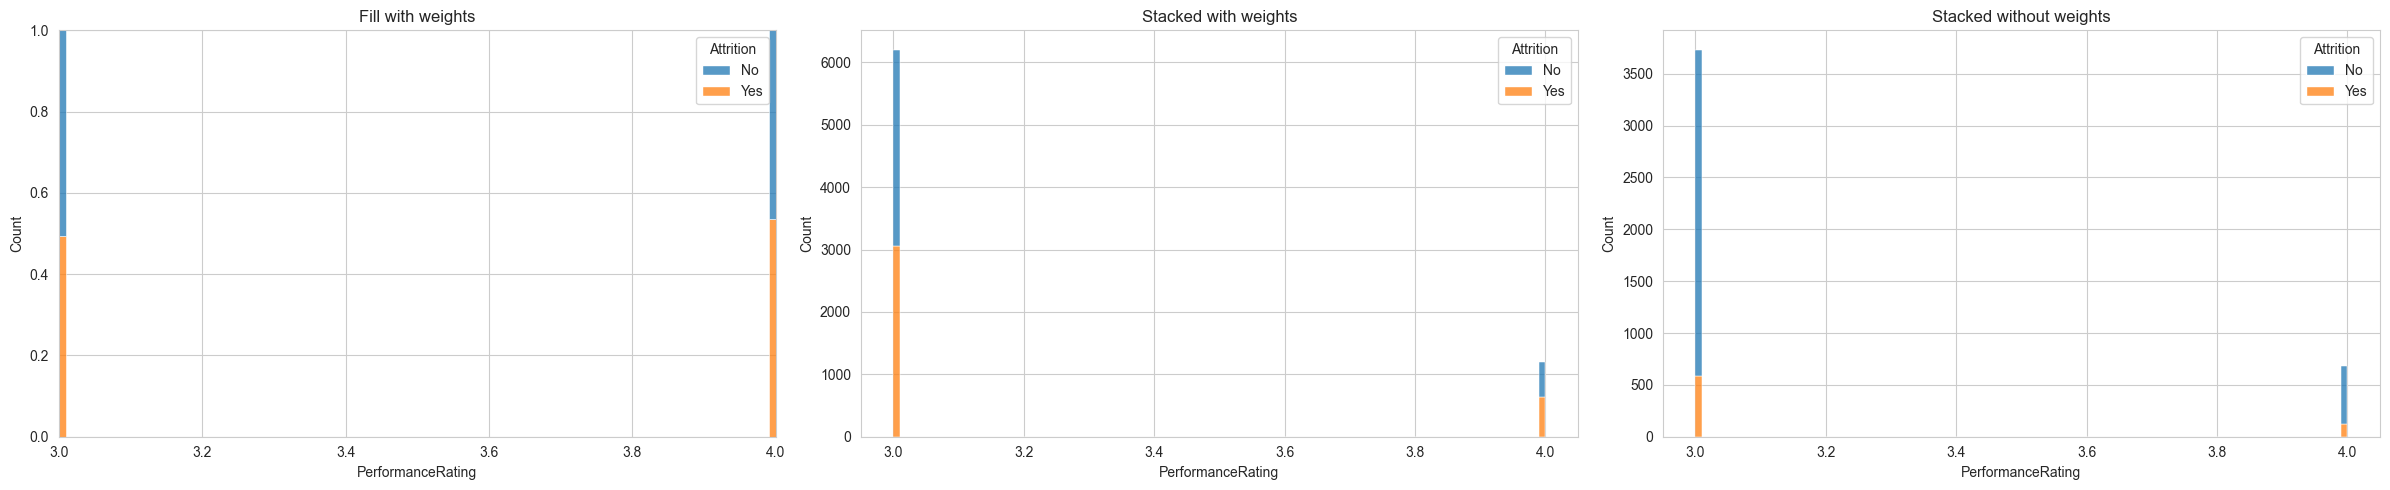

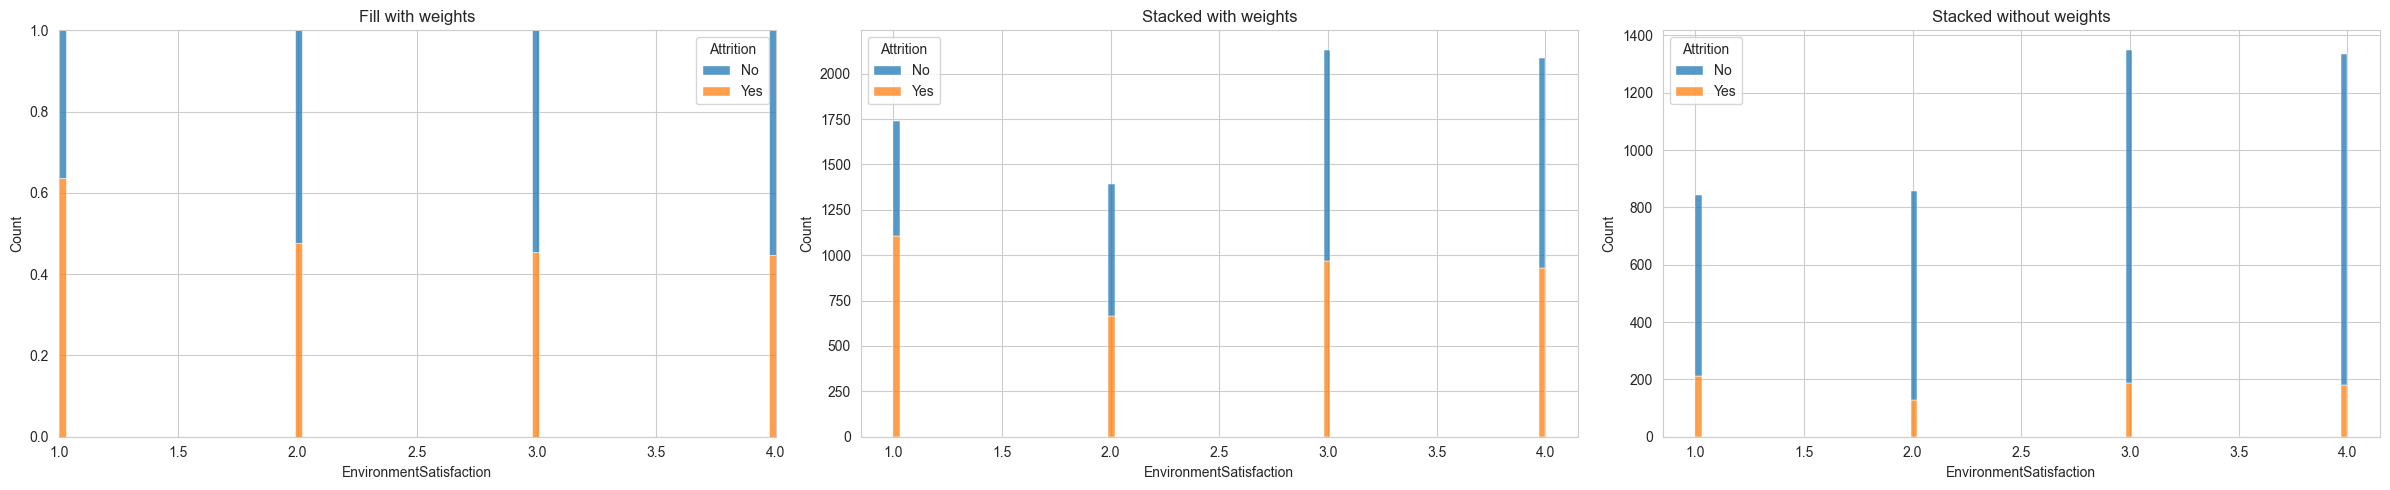

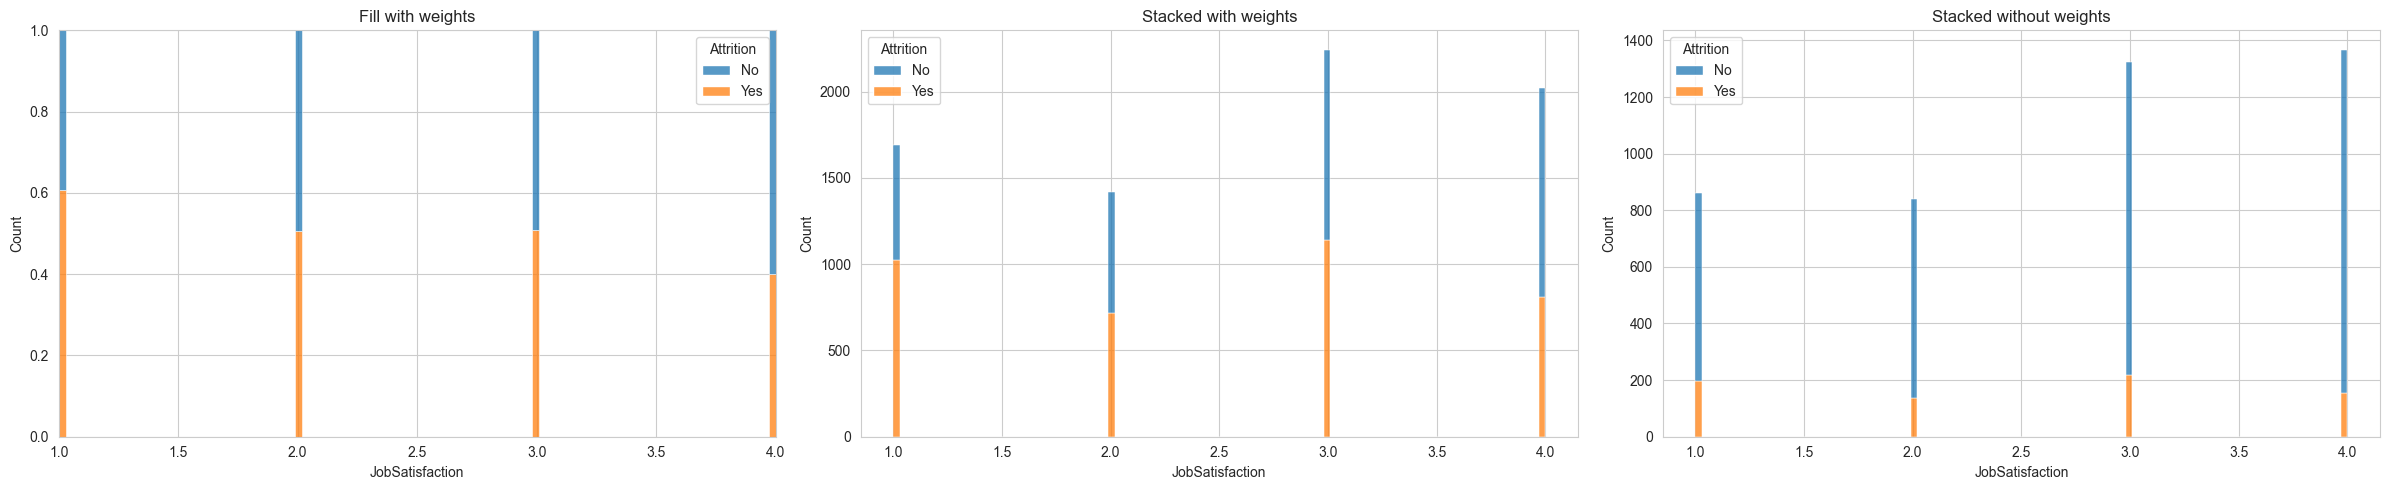

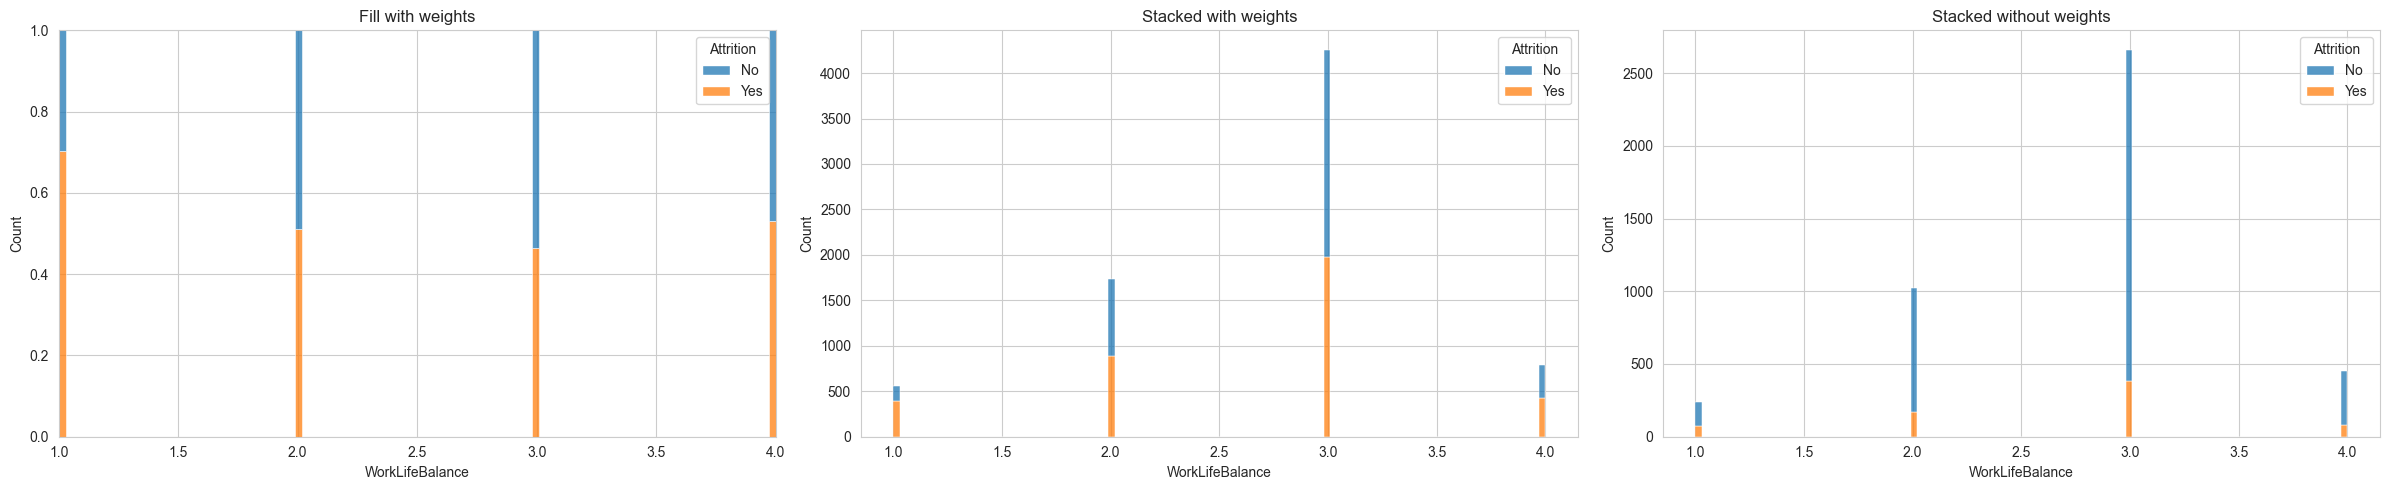

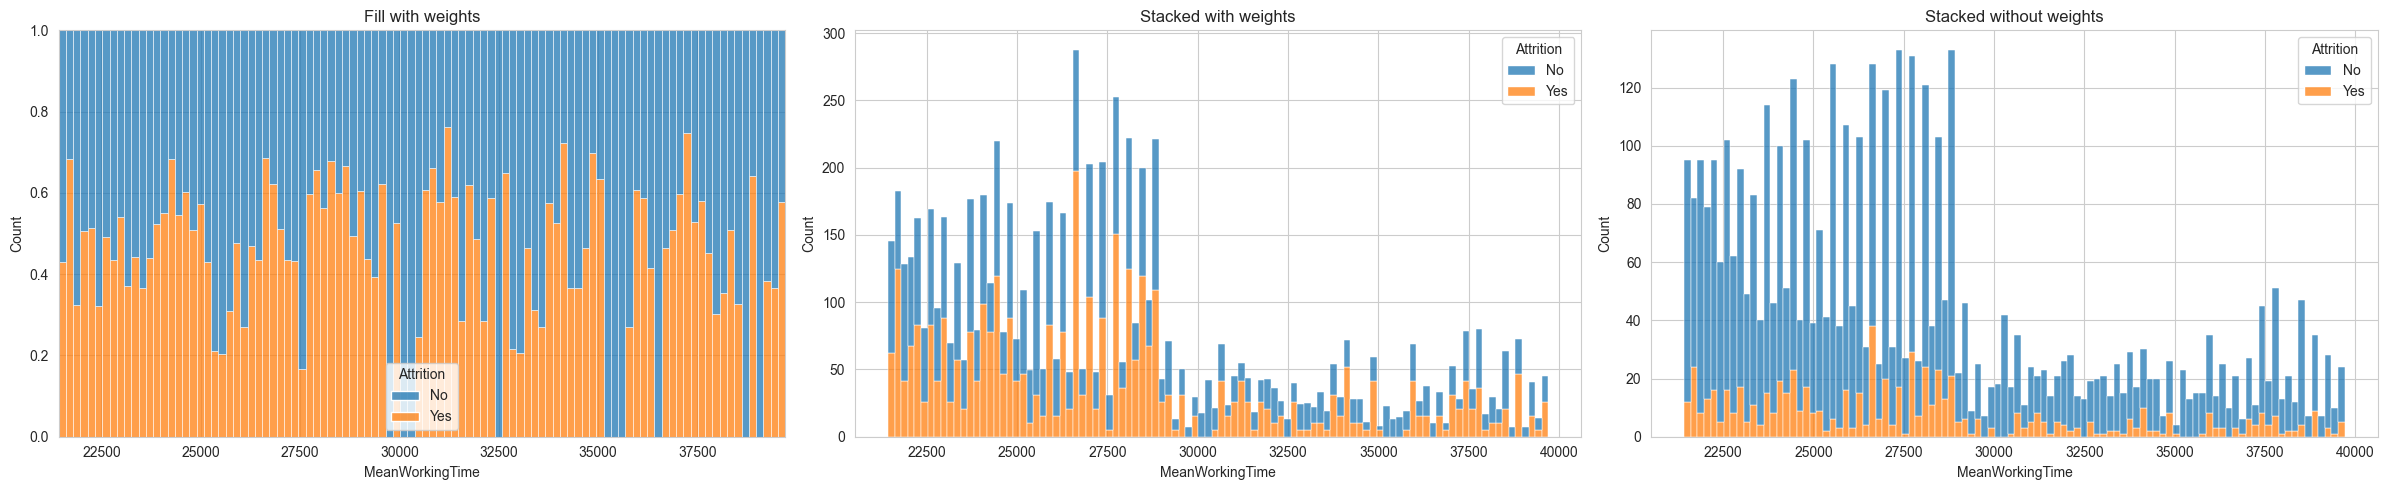

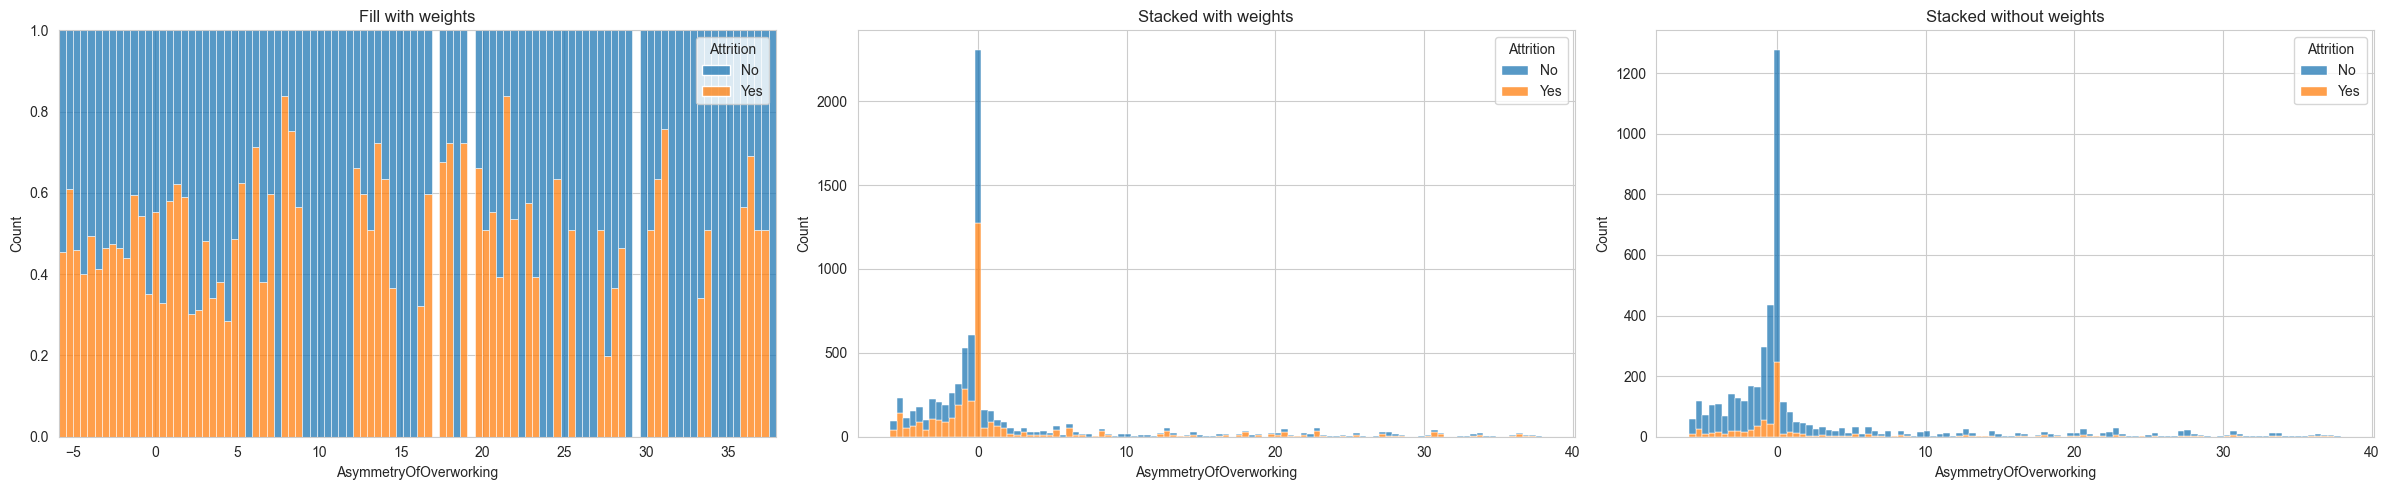

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns

log_scaled = {'Asymmetry of overworking'}

for i in range(len(data.columns)):
    _, ax = plt.subplots(nrows=1, ncols=3, figsize=(24, 5))
    ax[0].set_title('Fill with weights')
    ax[1].set_title('Stacked with weights')
    ax[2].set_title('Stacked without weights')
    sns.histplot(data=data, hue='Attrition', x=data.columns[i], log_scale=data.columns[i] in log_scaled,
                 multiple='fill', weights=weights, ax=ax[0], bins=100)
    sns.histplot(data=data, hue='Attrition', x=data.columns[i], log_scale=data.columns[i] in log_scaled,
                 multiple='stack', weights=weights, ax=ax[1], bins=100)
    sns.histplot(data=data, hue='Attrition', x=data.columns[i], log_scale=data.columns[i] in log_scaled,
                 multiple='stack', ax=ax[2], bins=100)
    if data[data.columns[i]].dtype == object:
        for j in range(3):
            ax[j].xaxis.set_tick_params(rotation=90)
    plt.tight_layout()
    plt.show()